# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model


In [1]:
import condensate_speckle
from condensate_speckle.data_io import*
from condensate_speckle.inference.model import*
from condensate_speckle.inference.simulation import *

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
az.style.use("arviz-darkgrid")

# General model & simulating data

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=\sum_{i=1}^{p}\phi_i\times Y_{t-i}+e_t$, where $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $e_t$ is the innovation term. For this project, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=\phi\times Y_{t-1}+e_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=\exp(-1/\tau)\times Y_{t-1}+e_t$. 

We need to specify three variables in order to build the generative model: the mean $c$ and standard deviation $\sigma_e$ of the innovation term $e_t$, and decay time $\tau$. Here, $e_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the distribution noise level of microscope, which is assumed to be a Normal distribution as well.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

## simulate single time scale

In [3]:
number_of_points=5000
tau=10
quantization=255
intensity_mean=80
intensity_std=20
camera_noise=5
camera_std=1

The set mean of innovation is 7.613006557123239
The set std of innovation is 8.515145258232963


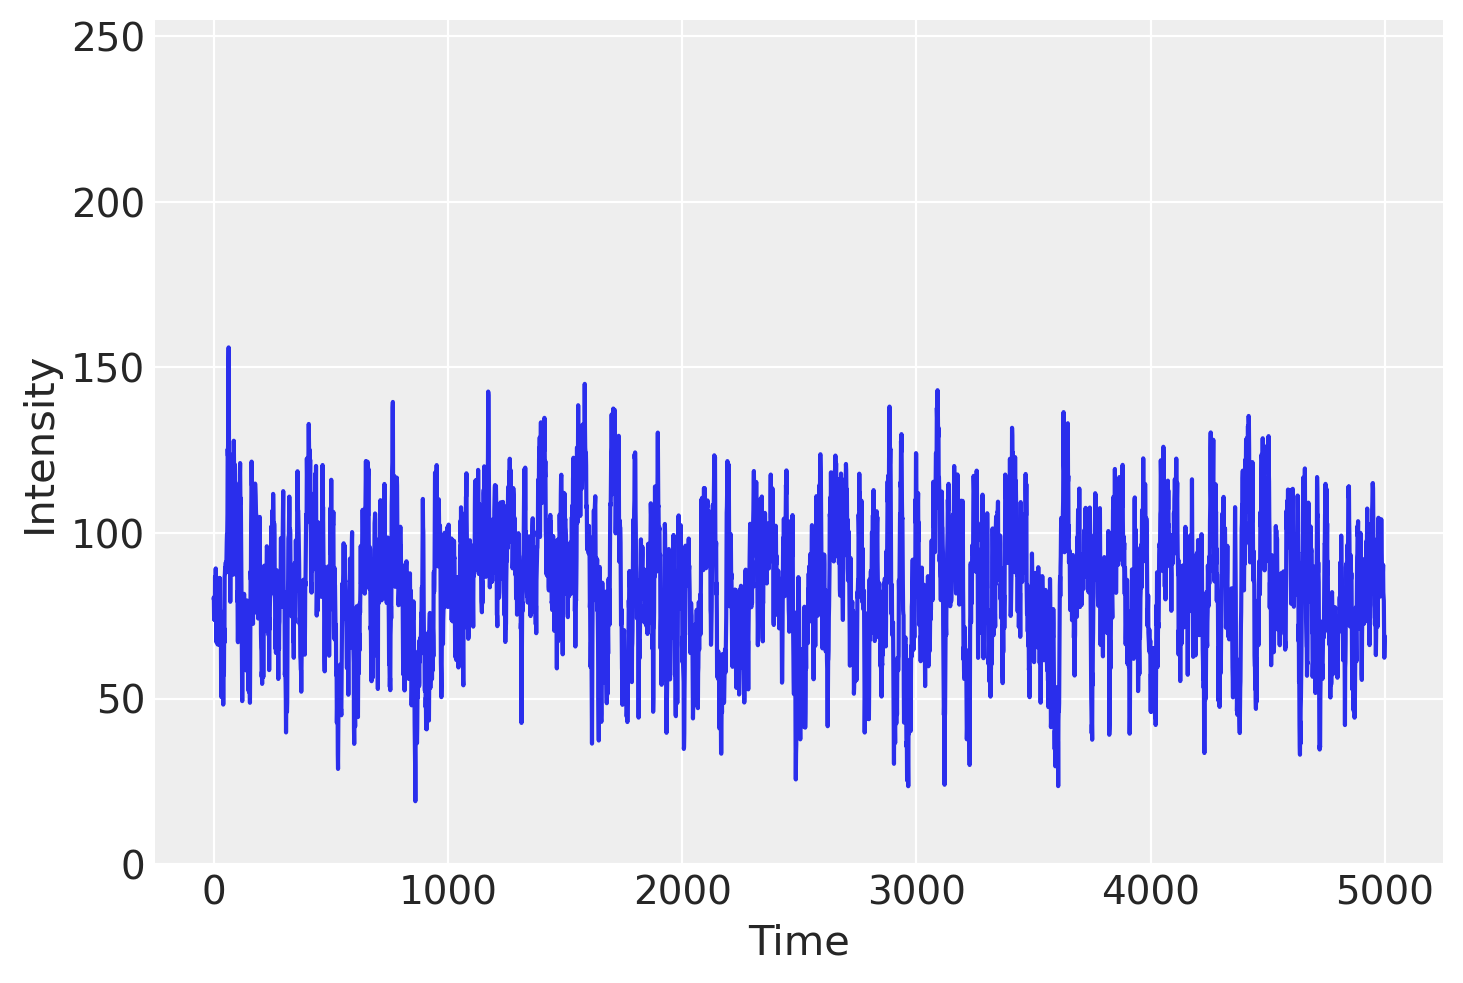

the mean of simulated data is 84.53946573910974
the std of simulated data is 20.133745496600422


In [4]:
simulated_data_single, simulated_t_single=simulate_single_decay_data(number_of_points,tau, quantization, intensity_mean, intensity_std, camera_noise, camera_std)

## simulate 2 time scales

In [5]:
number_of_points=5000
tau_1=3
tau_2=300
relative_var=0.5
quantization=255
intensity_mean=80
intensity_std=40
camera_noise=8
camera_std=3

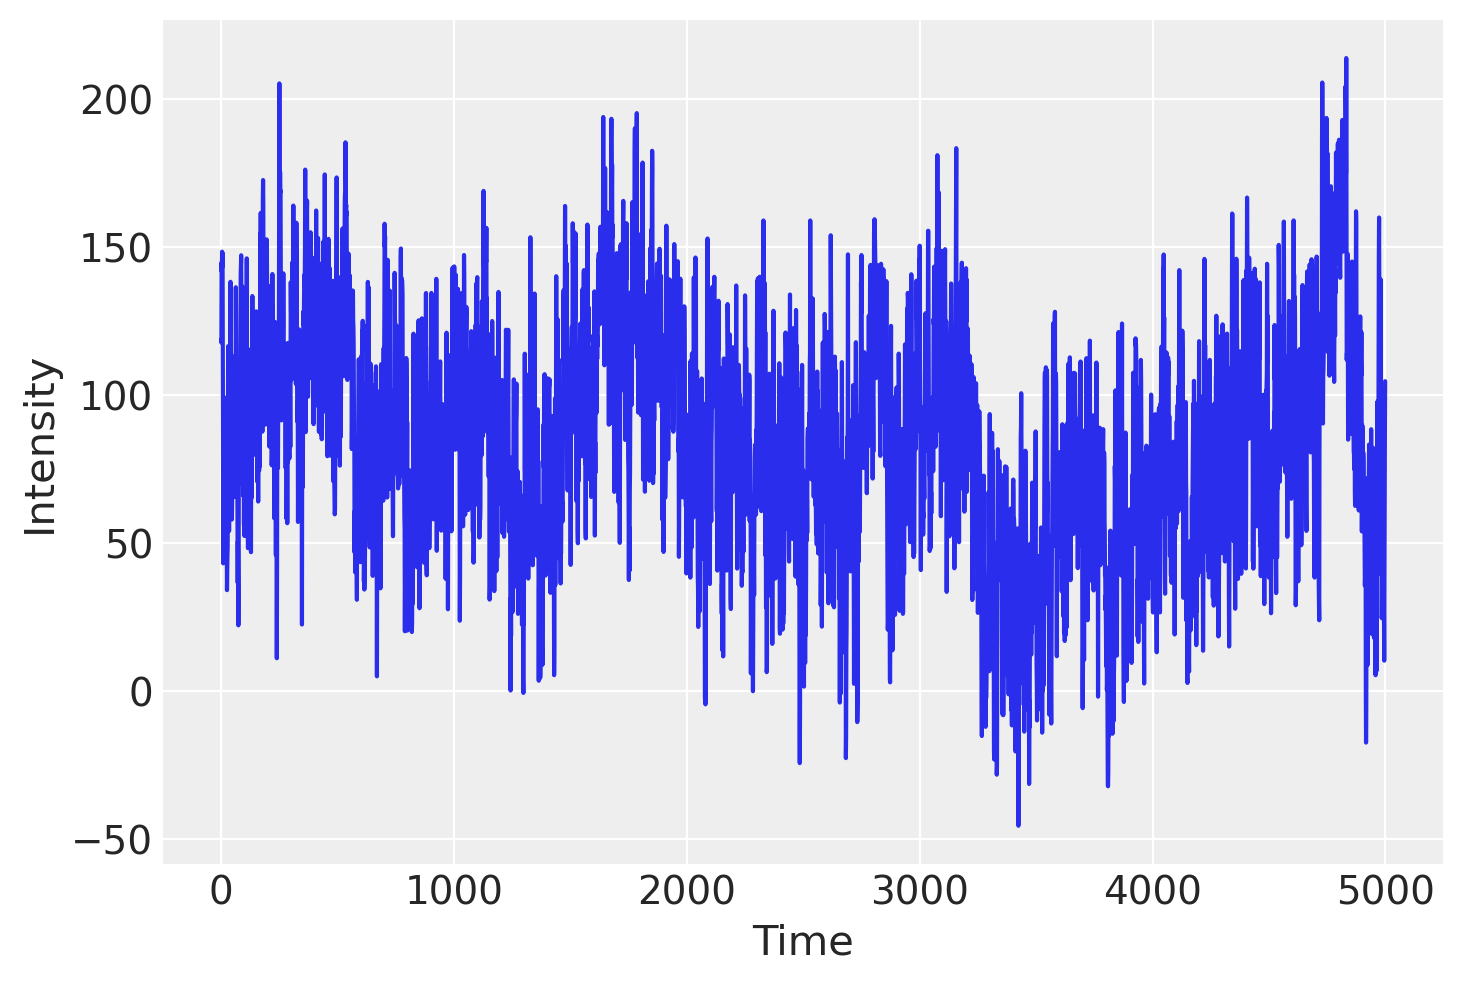

the mean of camera noise data is 8.02026936824944
the std of camera noise data is 2.990613740299076
the mean of fast simulated data is 1.837347604959657
the mean of slow simulated data is -4.879970336371468
the mean of simulated data is 84.97764663683763
the std of simulated data is 38.00196320400628
the (variance/mean^2) of simulated data is 0.19998741508017842


In [6]:
simulated_data_double, simulated_t_double=simulate_double_decay_data(number_of_points,tau_1,tau_2, relative_var,quantization, intensity_mean, intensity_std, camera_noise, camera_std)

# Load in real data

/Users/anqichen/Documents/GitHub/condensate_speckles/condensate_speckle/example_data/[120, 145]_intensity.csv


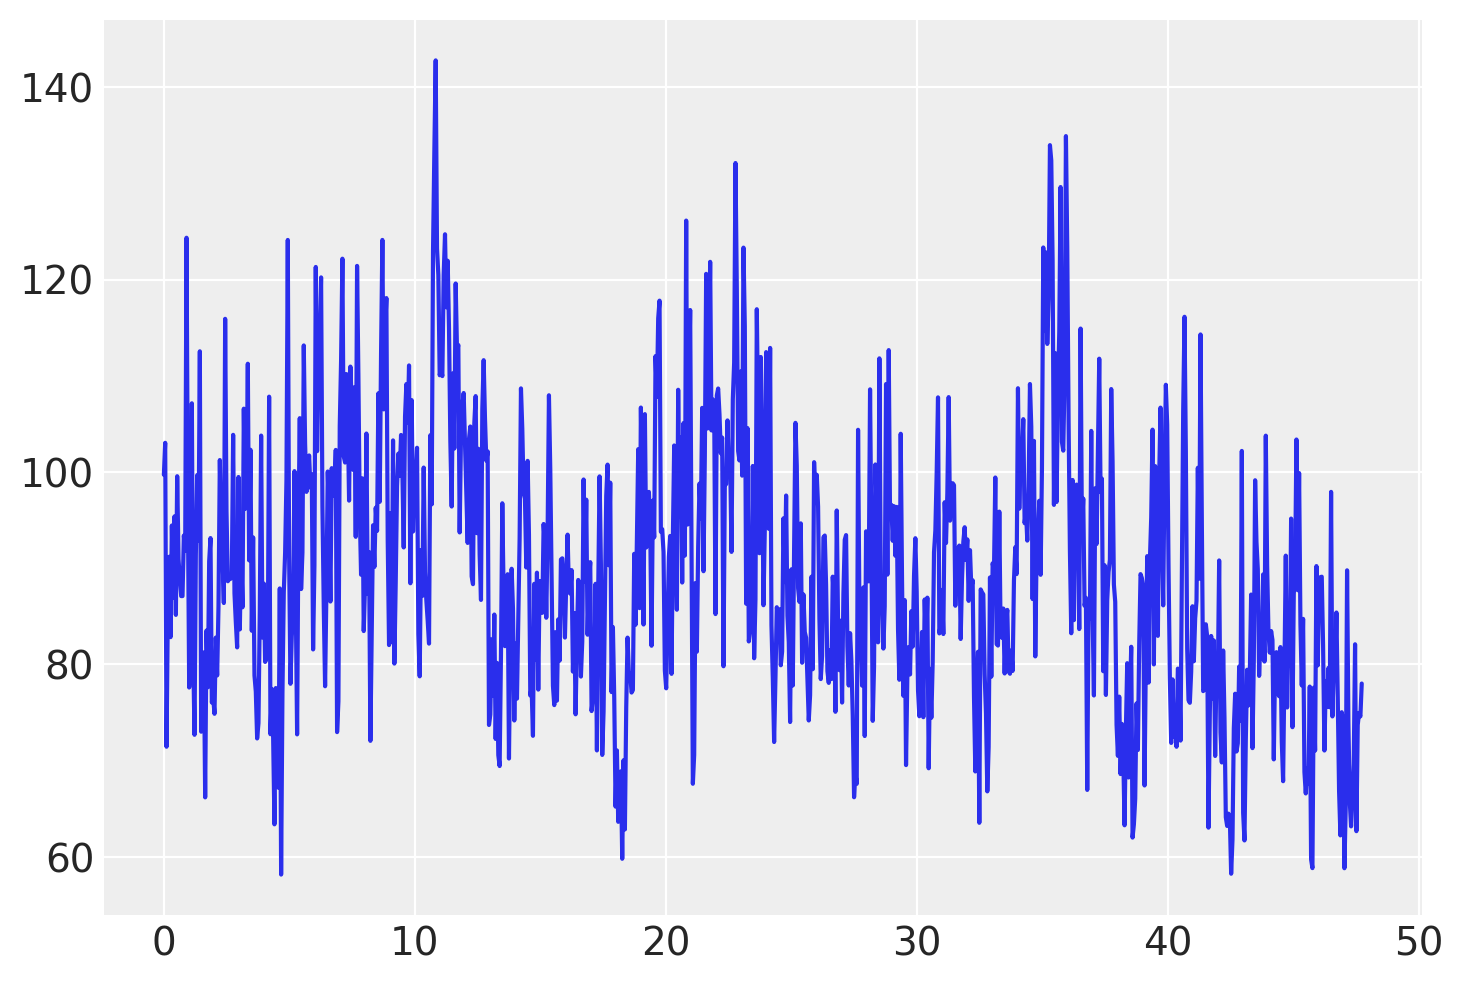

In [7]:
#Load in real data and plot
dataframe = load_data('[120, 145]_intensity.csv',data_dir='condensate_speckle/example_data')

/Users/anqichen/Documents/GitHub/condensate_speckles/condensate_speckle/example_data/[110, 145]_intensity.csv


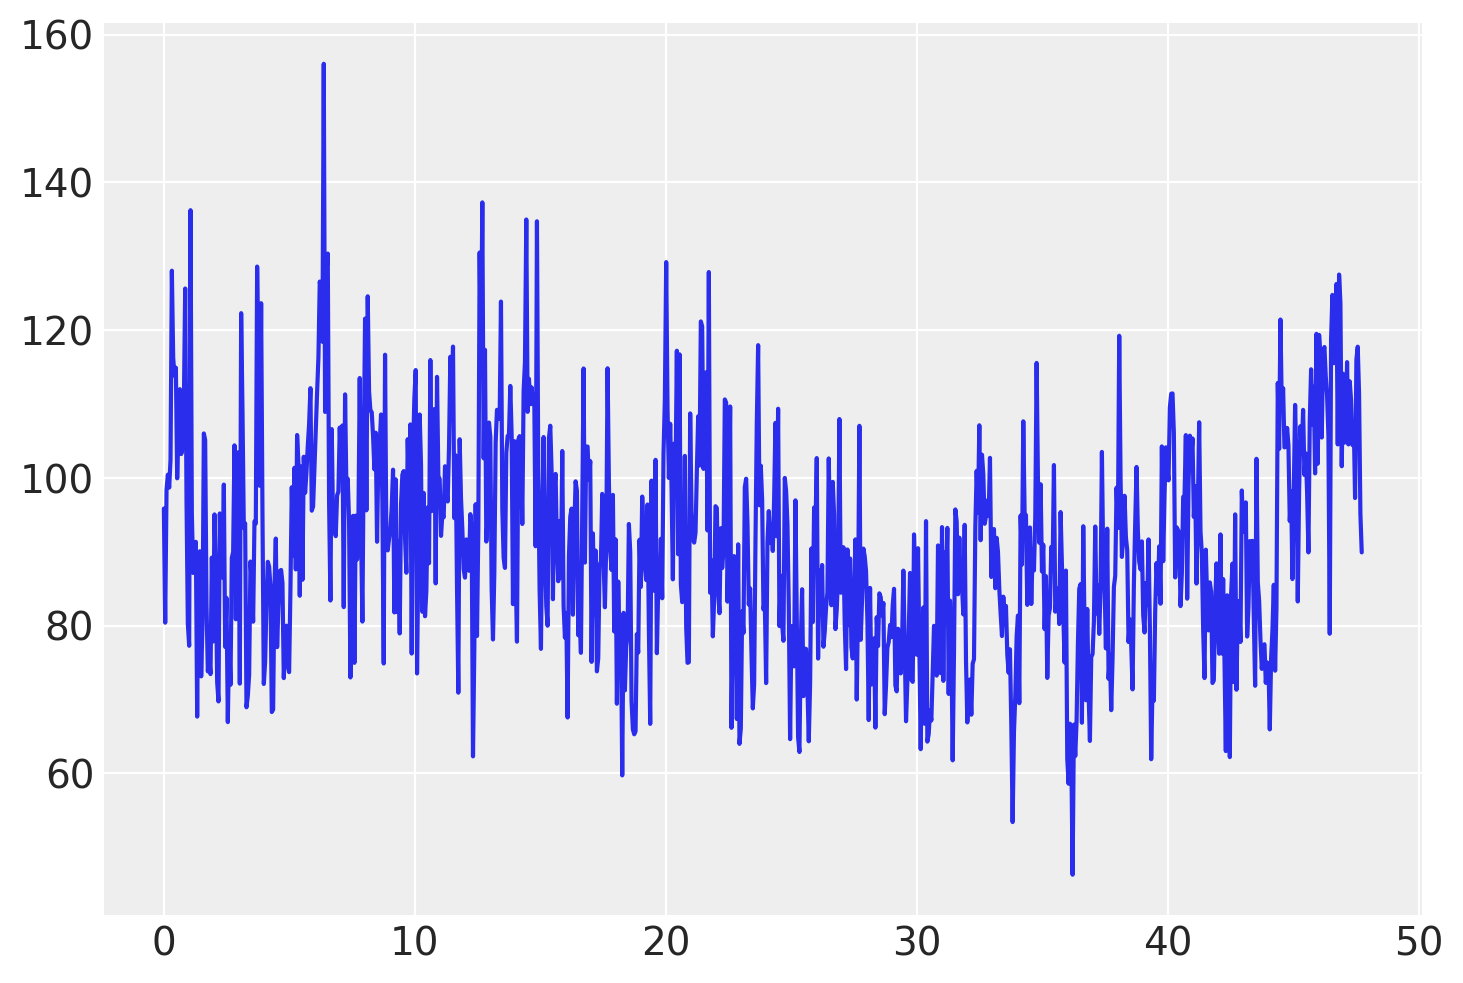

In [8]:
dataframe1=load_data('[110, 145]_intensity.csv',data_dir='condensate_speckle/example_data')

# Infer decay time from data using the AR(1) model in pymc3

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,500) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \text{camera_noise_std} \sim \text{Trunc} (I_{min}, I_{max}) $$
$$ \text{prediction} \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}) + \text{mean intensity} $$

$$ p(X) \sim \text{Normal} (\mu=\text{prediction}, \sigma=\text{camera_noise_std}) $$

In [9]:
# Define ar1 model
ar1_model=set_model(dataframe['Intensity'],quantization)

In [10]:
# Sample with pymc3 using the single timescale model
trace_single_model = run_model(ar1_model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,673.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, noise_std, precision, decay_time]


/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
The number of effective samples is smaller than 10% for some parameters.


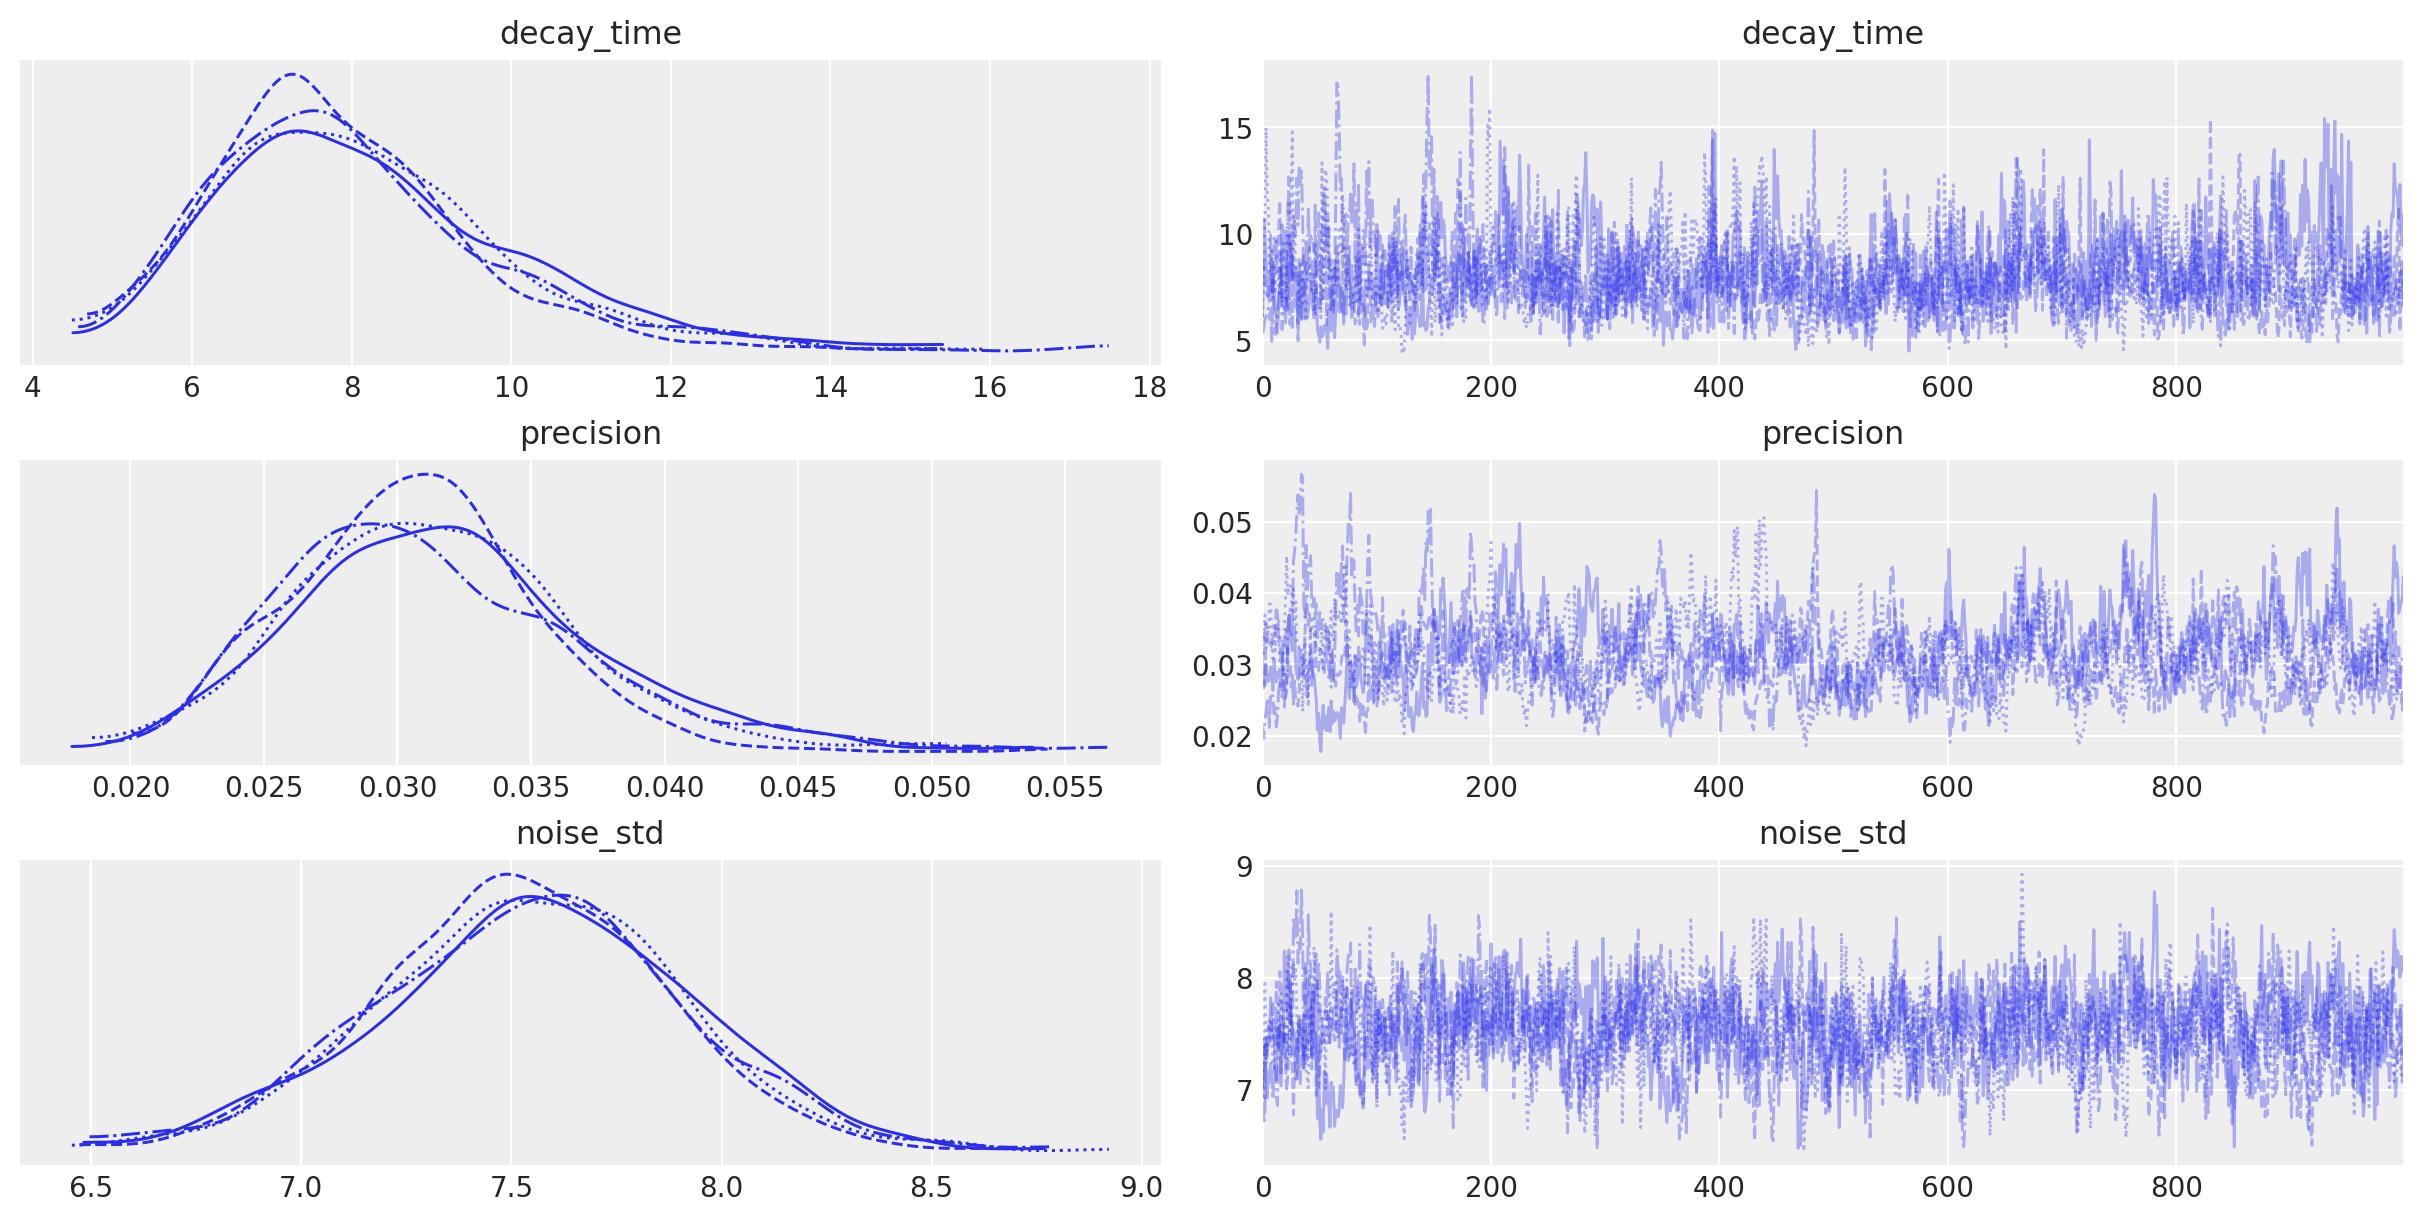

In [11]:
plot_trace(trace_single_model)

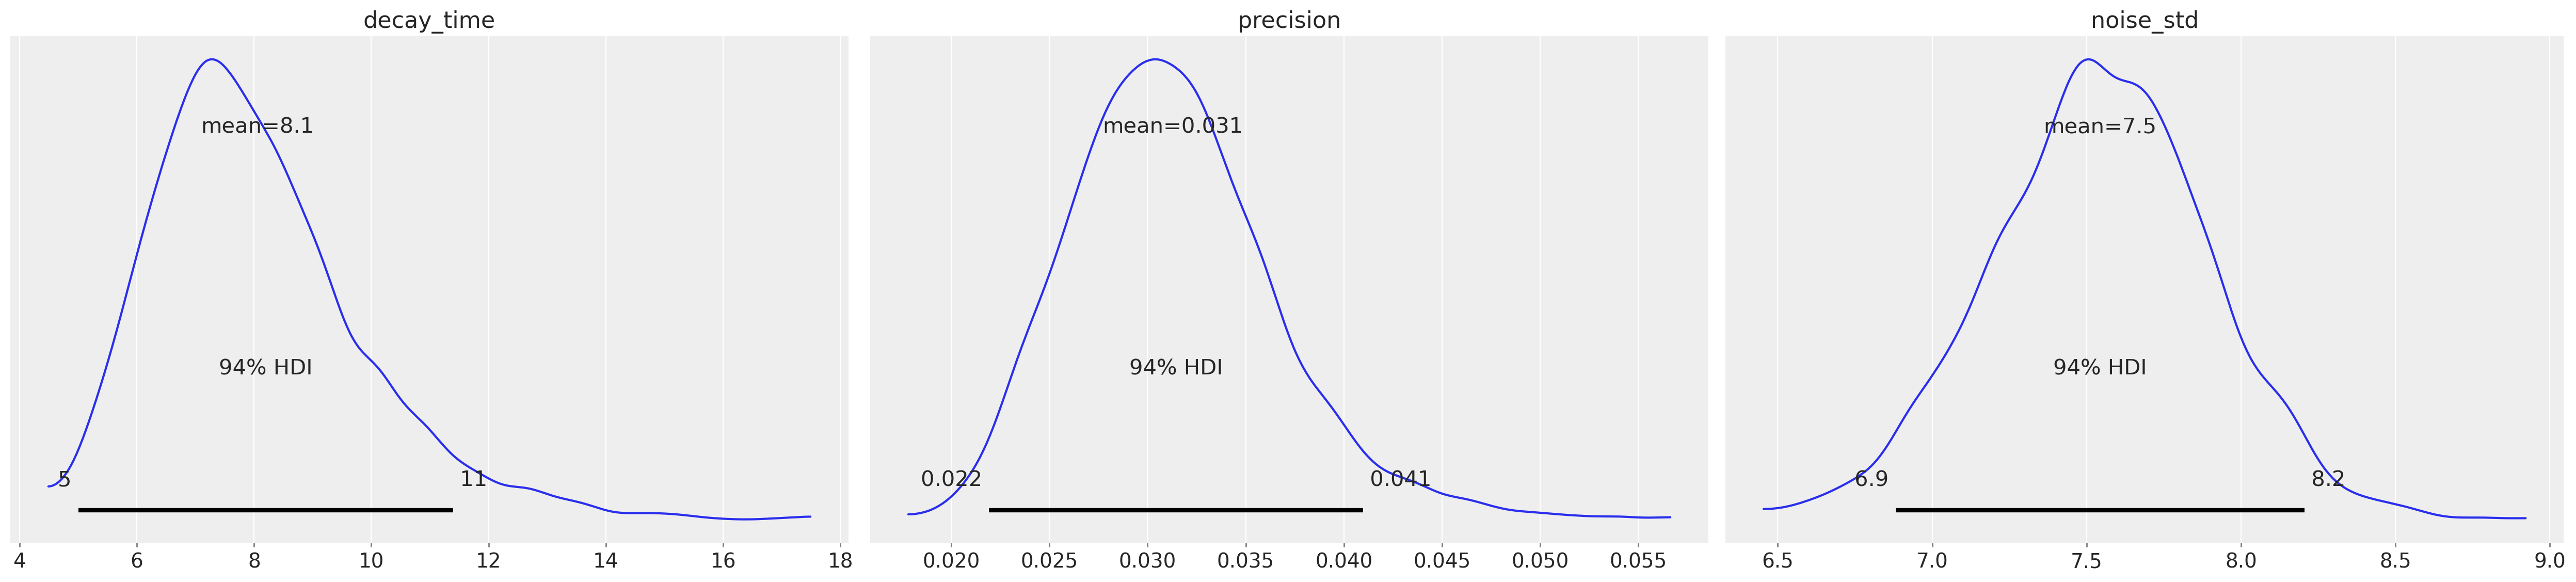

In [12]:
plot_posterior(trace_single_model)

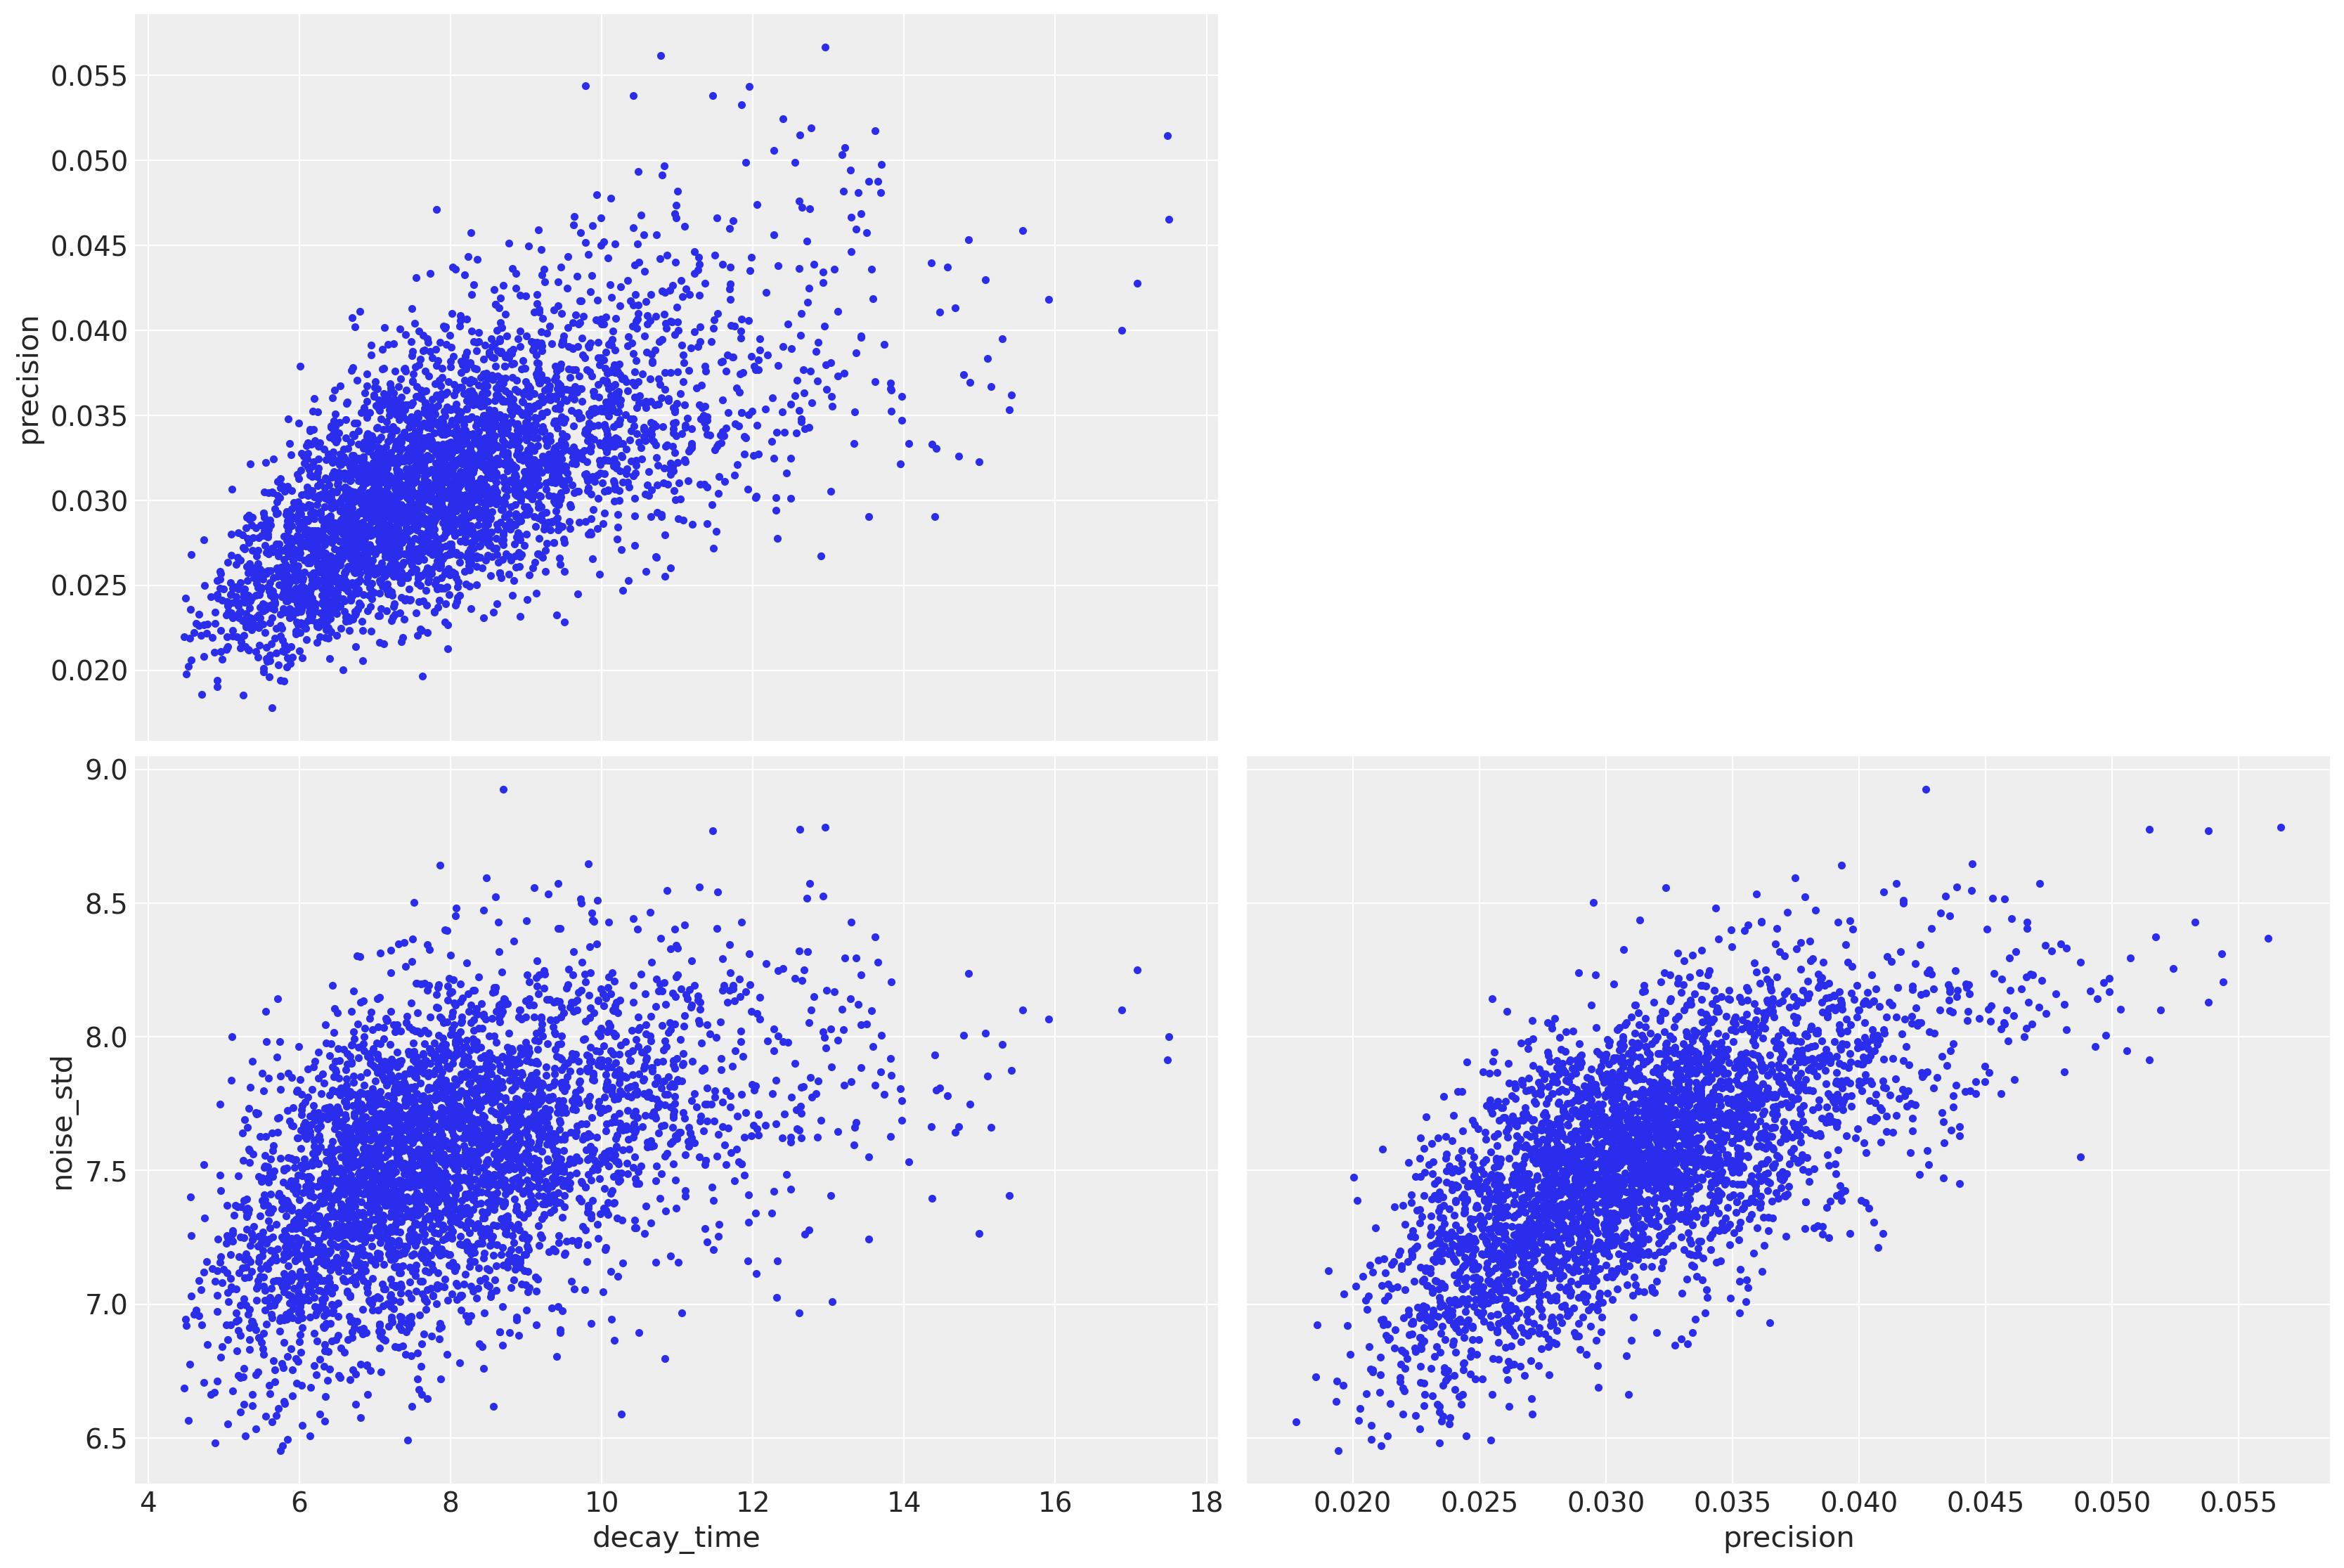

In [13]:
plot_pair(trace_single_model)

In [14]:
# Define ar1 model
ar1_model1=set_model(dataframe1['Intensity'],quantization)

In [15]:
# Sample with pymc3 using the single timescale model
trace_single_model1 = run_model(ar1_model1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,721.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, noise_std, precision, decay_time]


/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The esti

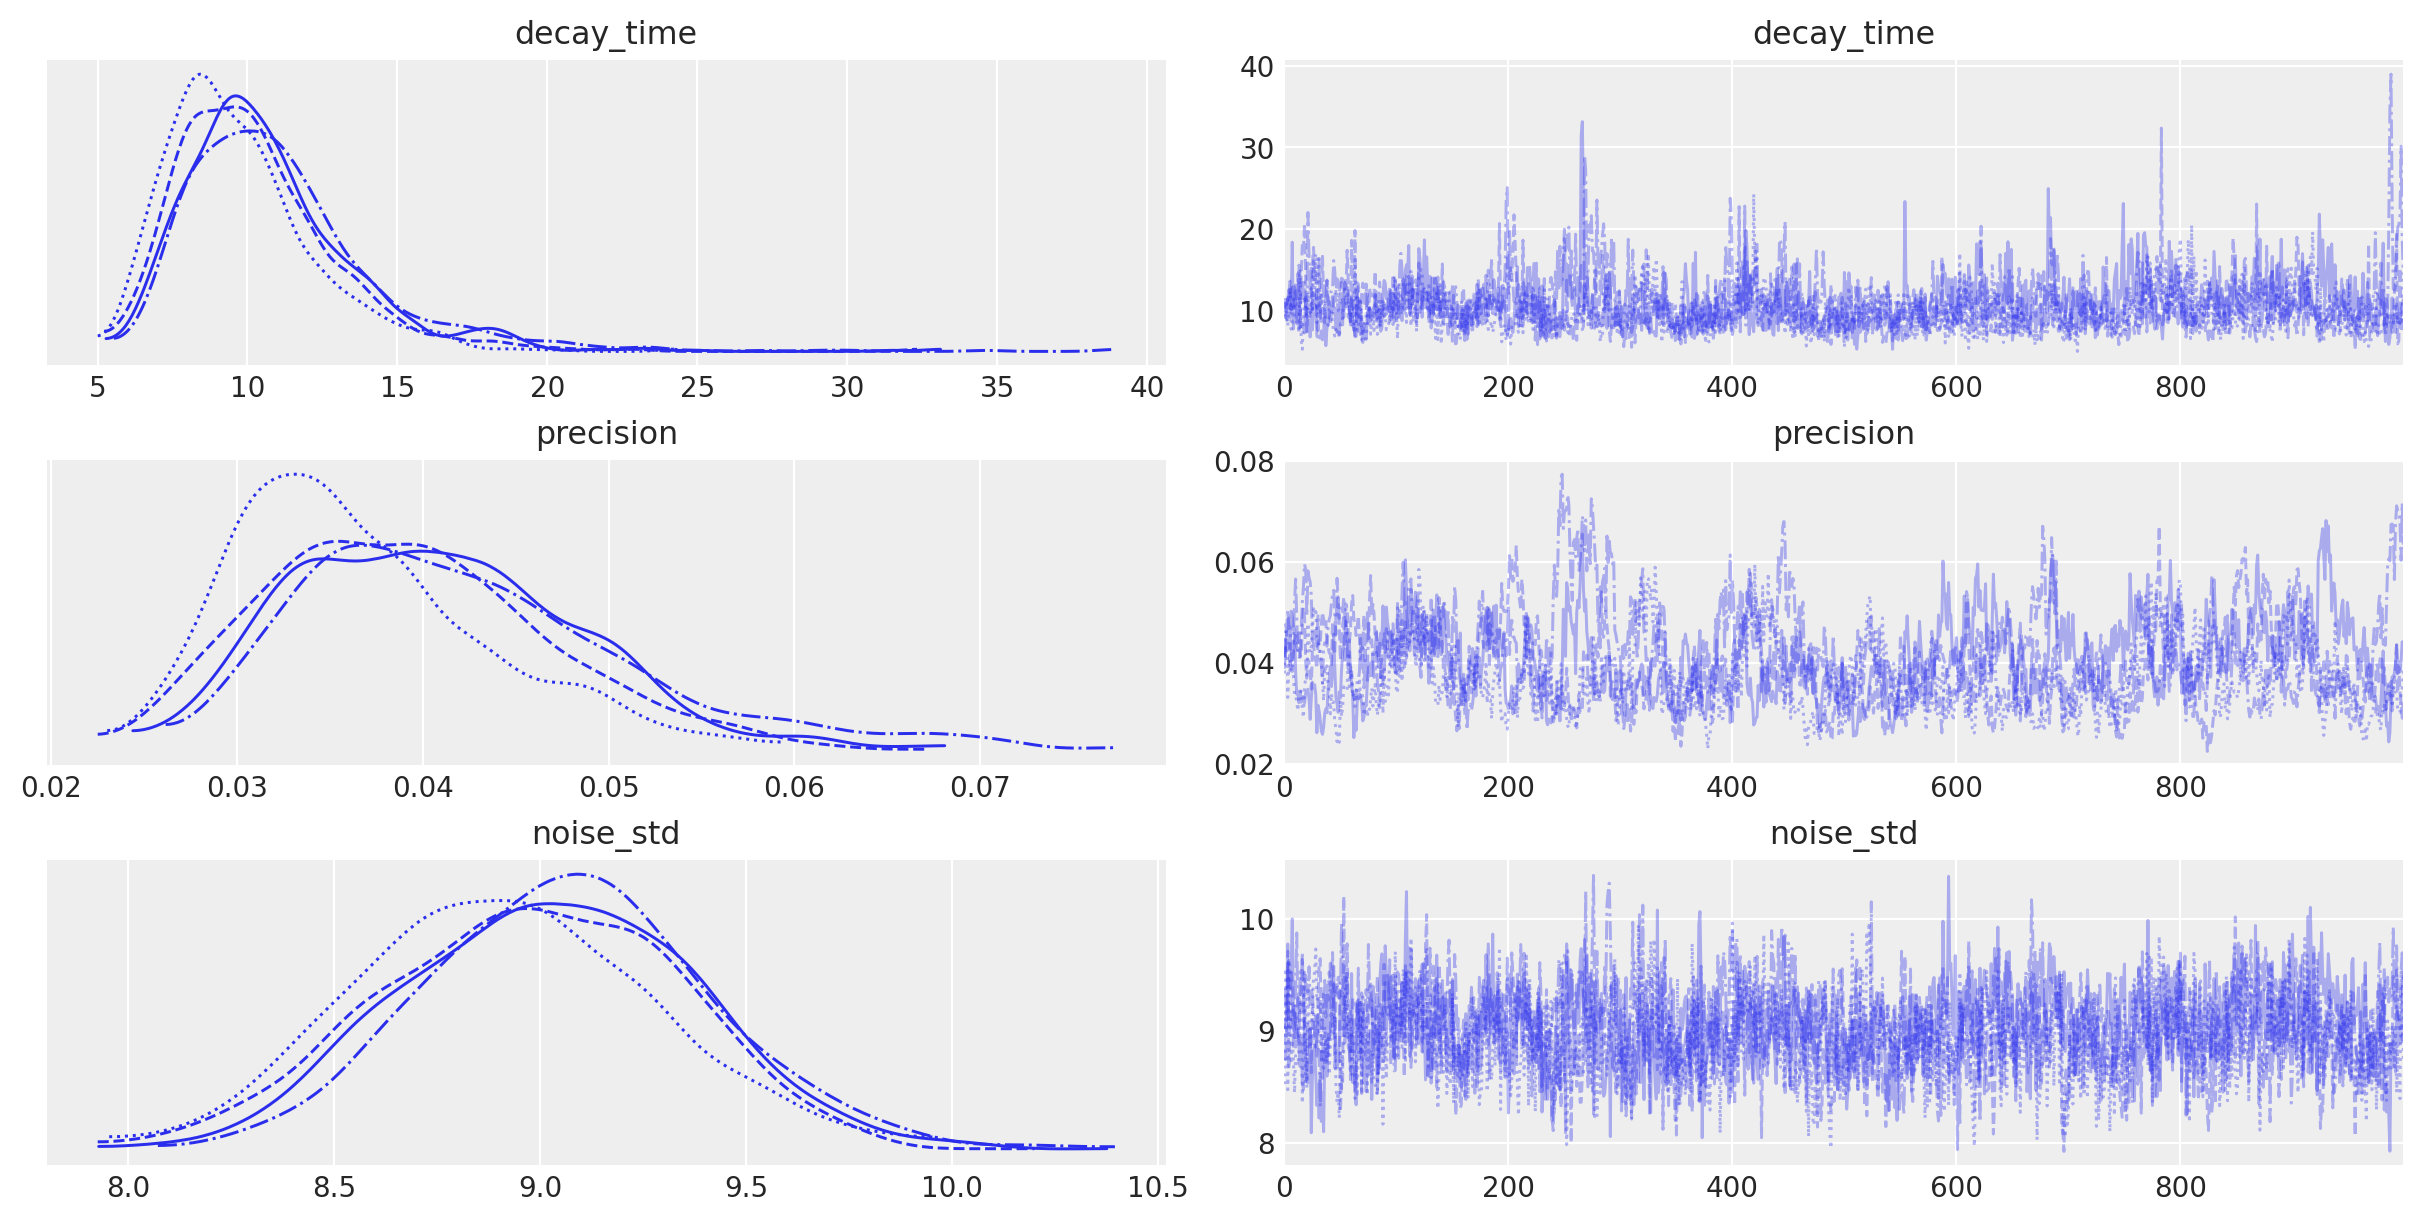

In [16]:
plot_trace(trace_single_model1)

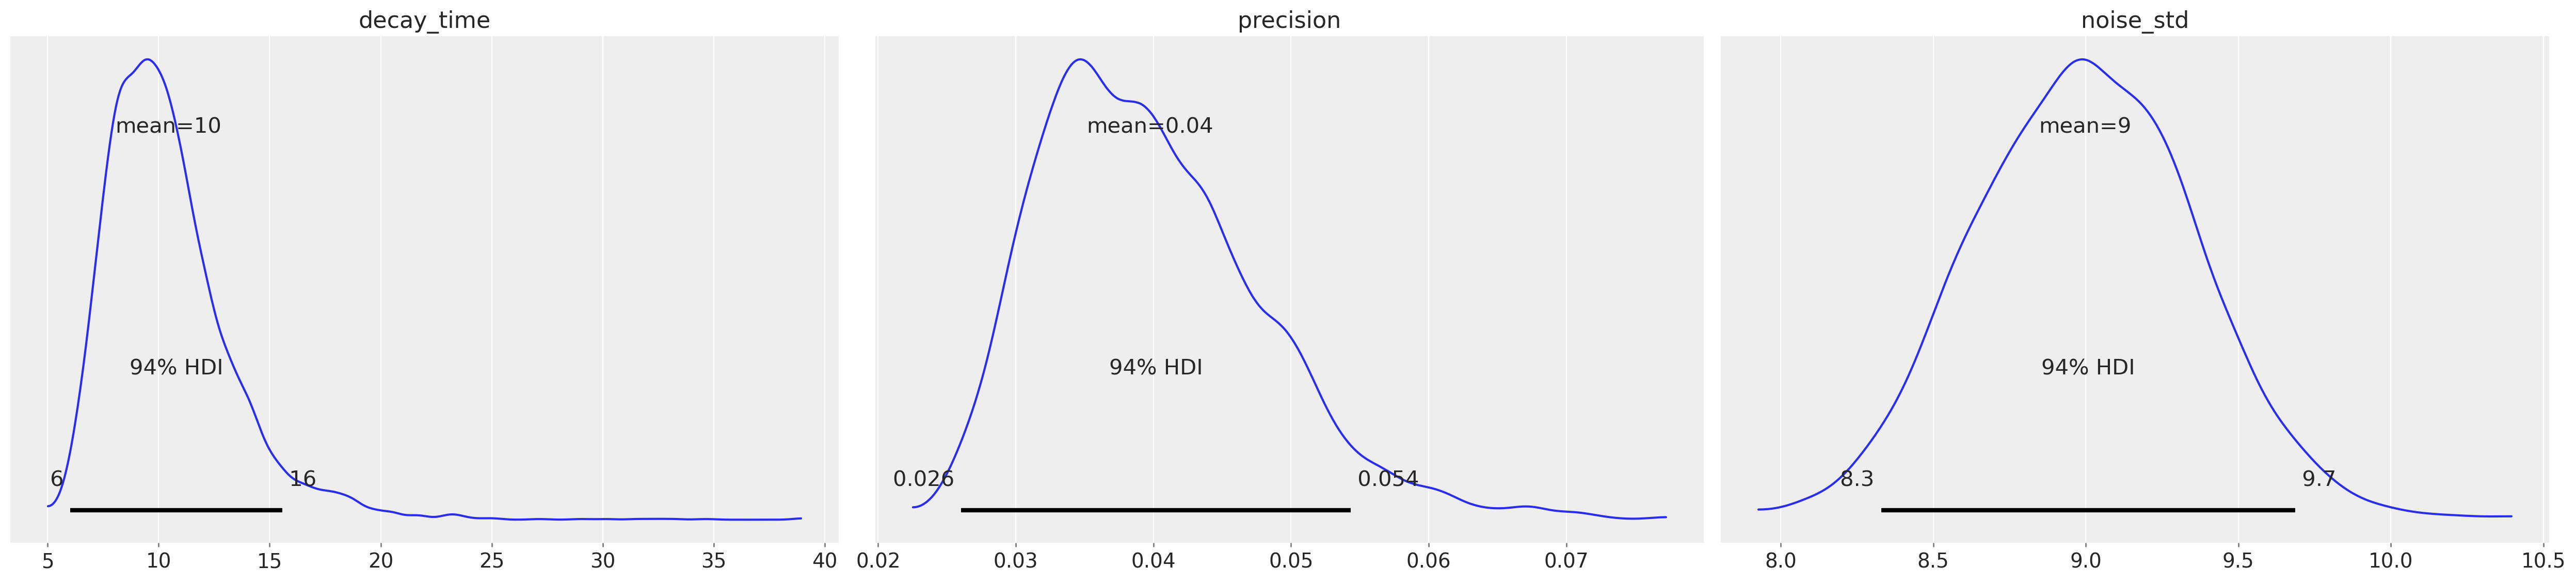

In [17]:
plot_posterior(trace_single_model1)

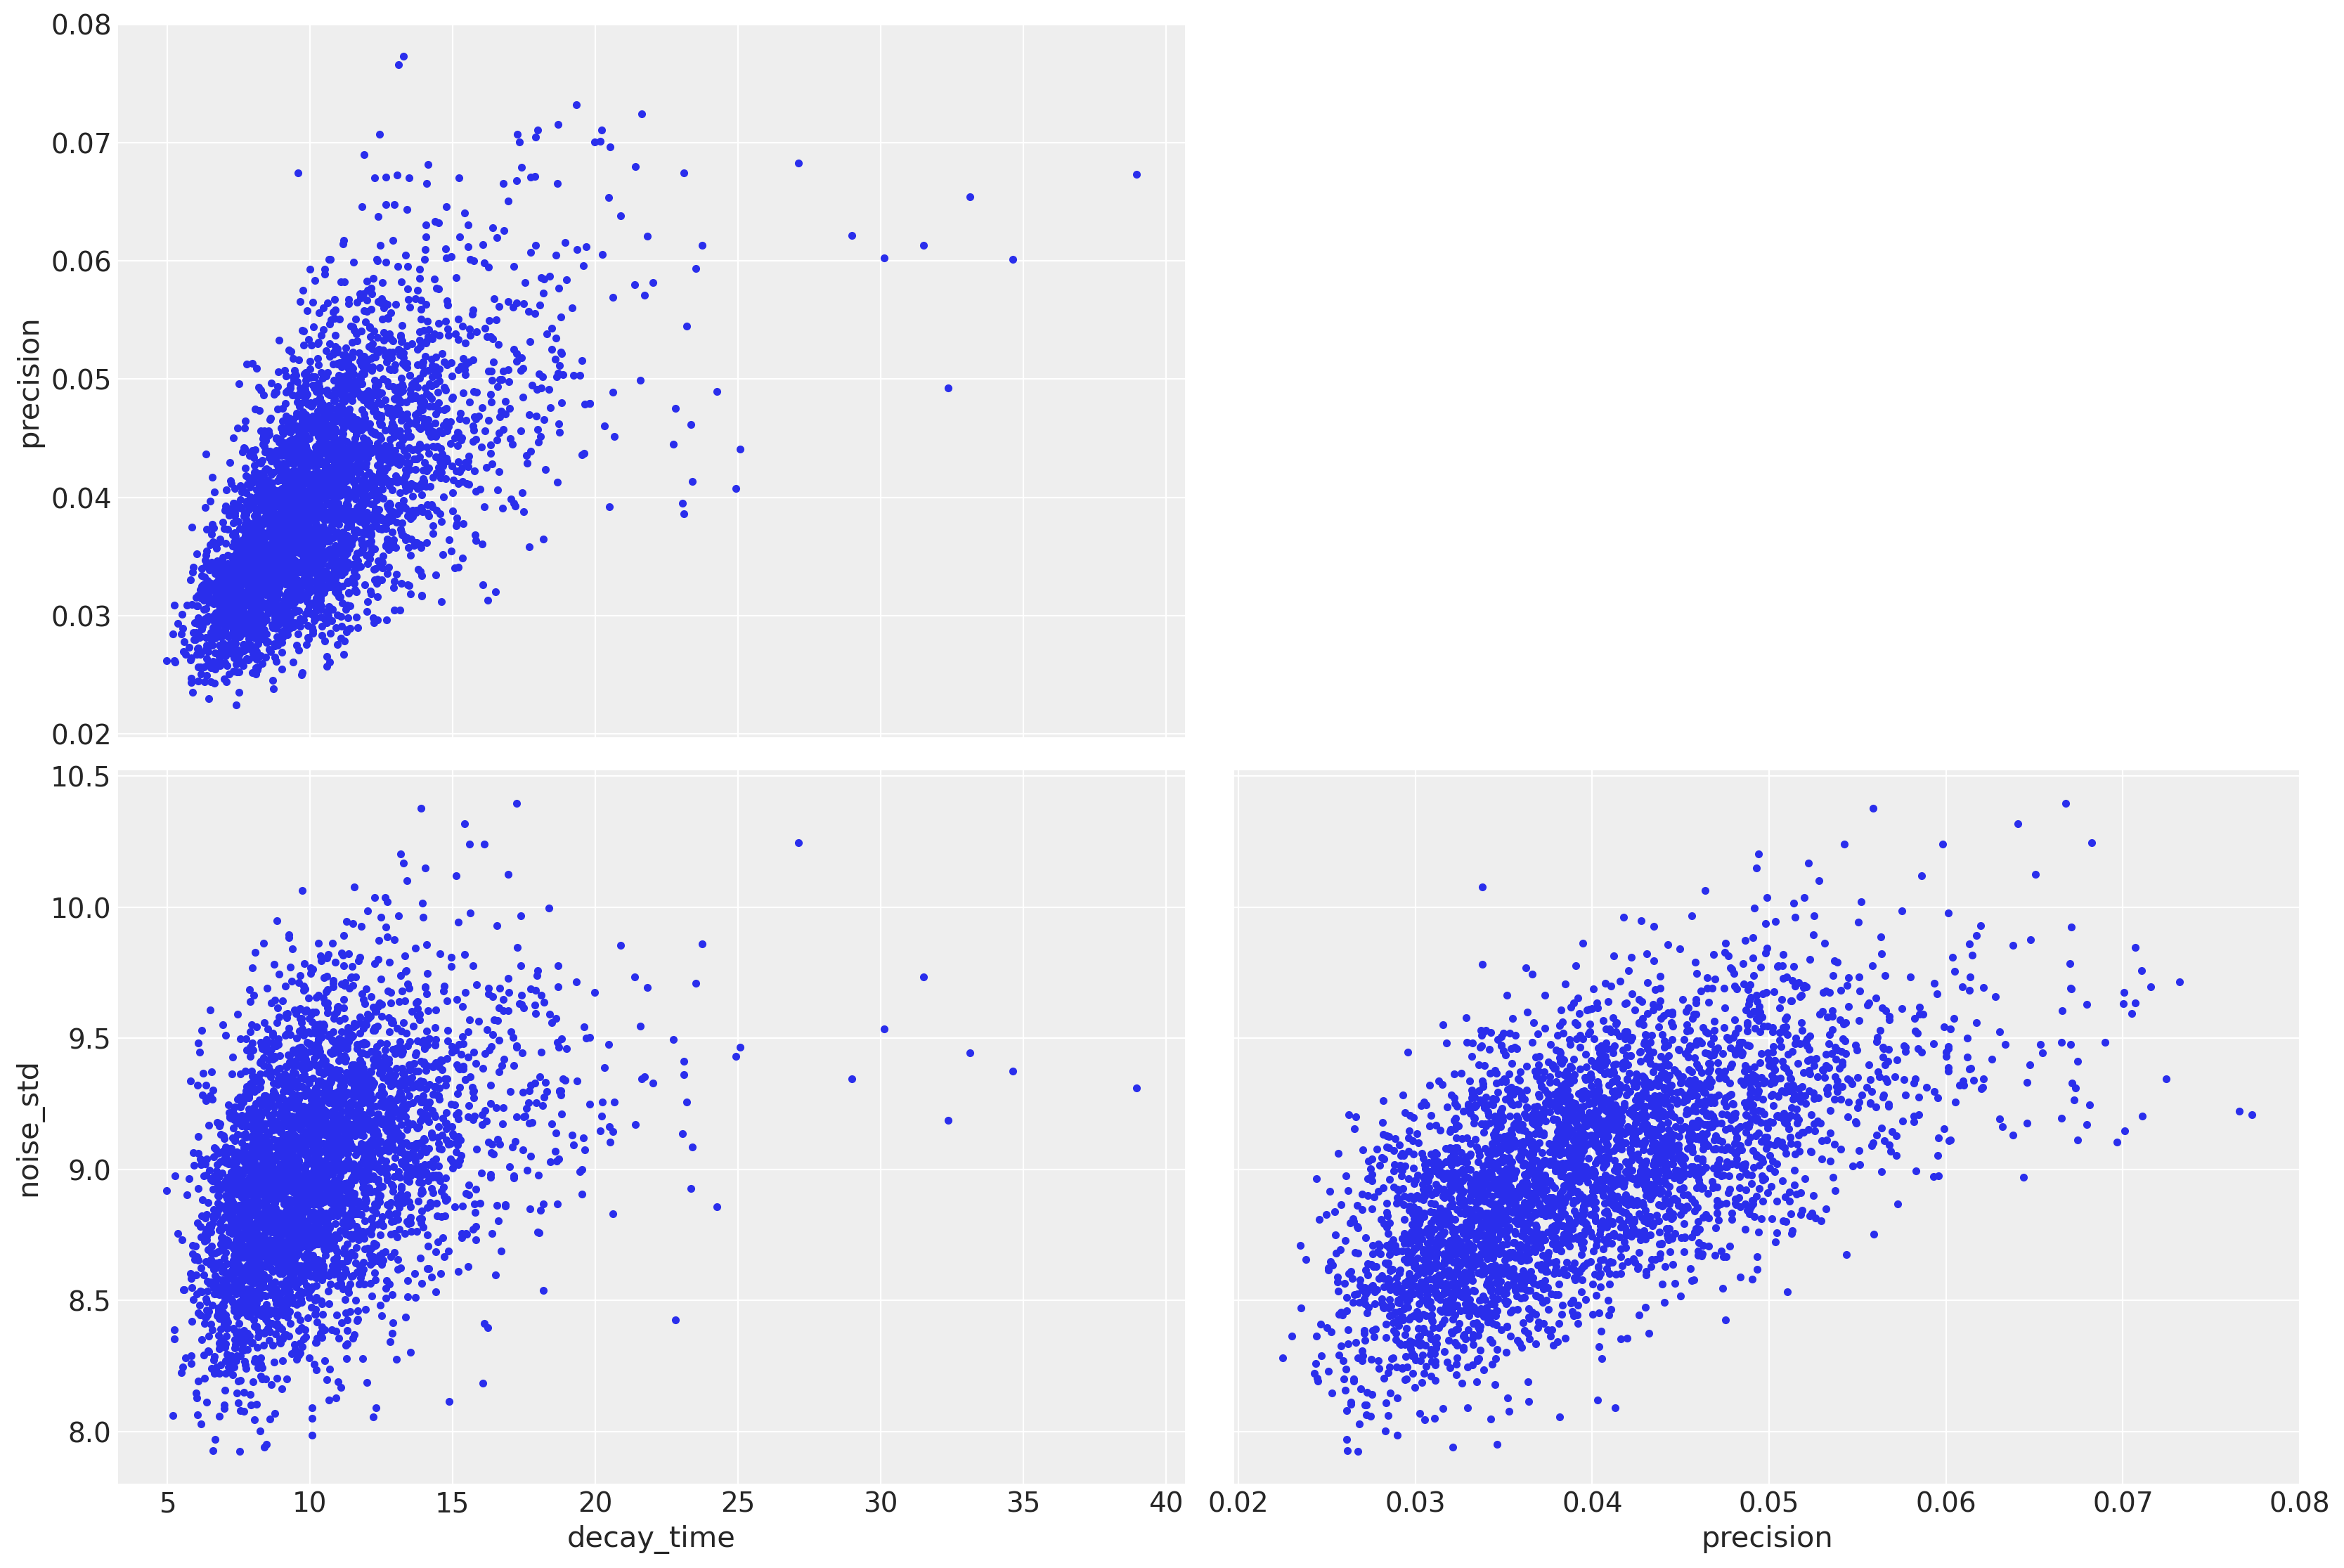

In [18]:
plot_pair(trace_single_model1)

# Infer decay time from data using the 2*AR(1) model in pymc3

The new generative model with two timescales is:
$$ \tau_{1} \sim \text{Uniform} (0,500) $$
$$ \tau_{separate} \sim \text{Uniform} (0,500) $$
$$ \tau_{2} \sim \tau_{1}+\tau_{separate}$$
$$ \text{precision} \sim \text{Uniform} (0, 10) $$
$$ \text{camera_noise_std} \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ \text{prediction} \sim \text{AR1} (\text{k} = e^{-1/\tau_{1}}, \text{tau_e} = \text{precision}) + \text{AR1} (\text{k} = e^{-1/\tau_{2}}, \text{tau_e} = \text{precision}) + \text{mean intensity} $$

$$ p(X) \sim \text{Normal} (\mu=\text{prediction}, \sigma=\text{camera_noise_std}) $$

In [29]:
ar1_multi_model=set_single_precision_model(dataframe['Intensity'], quantization)

In [30]:
# Sample with pymc3 using the double timescale model
trace_multi_model = run_model(ar1_multi_model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,696.1
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, noise_std, precision, decay_time_split, decay_time_1]


/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 56 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The esti

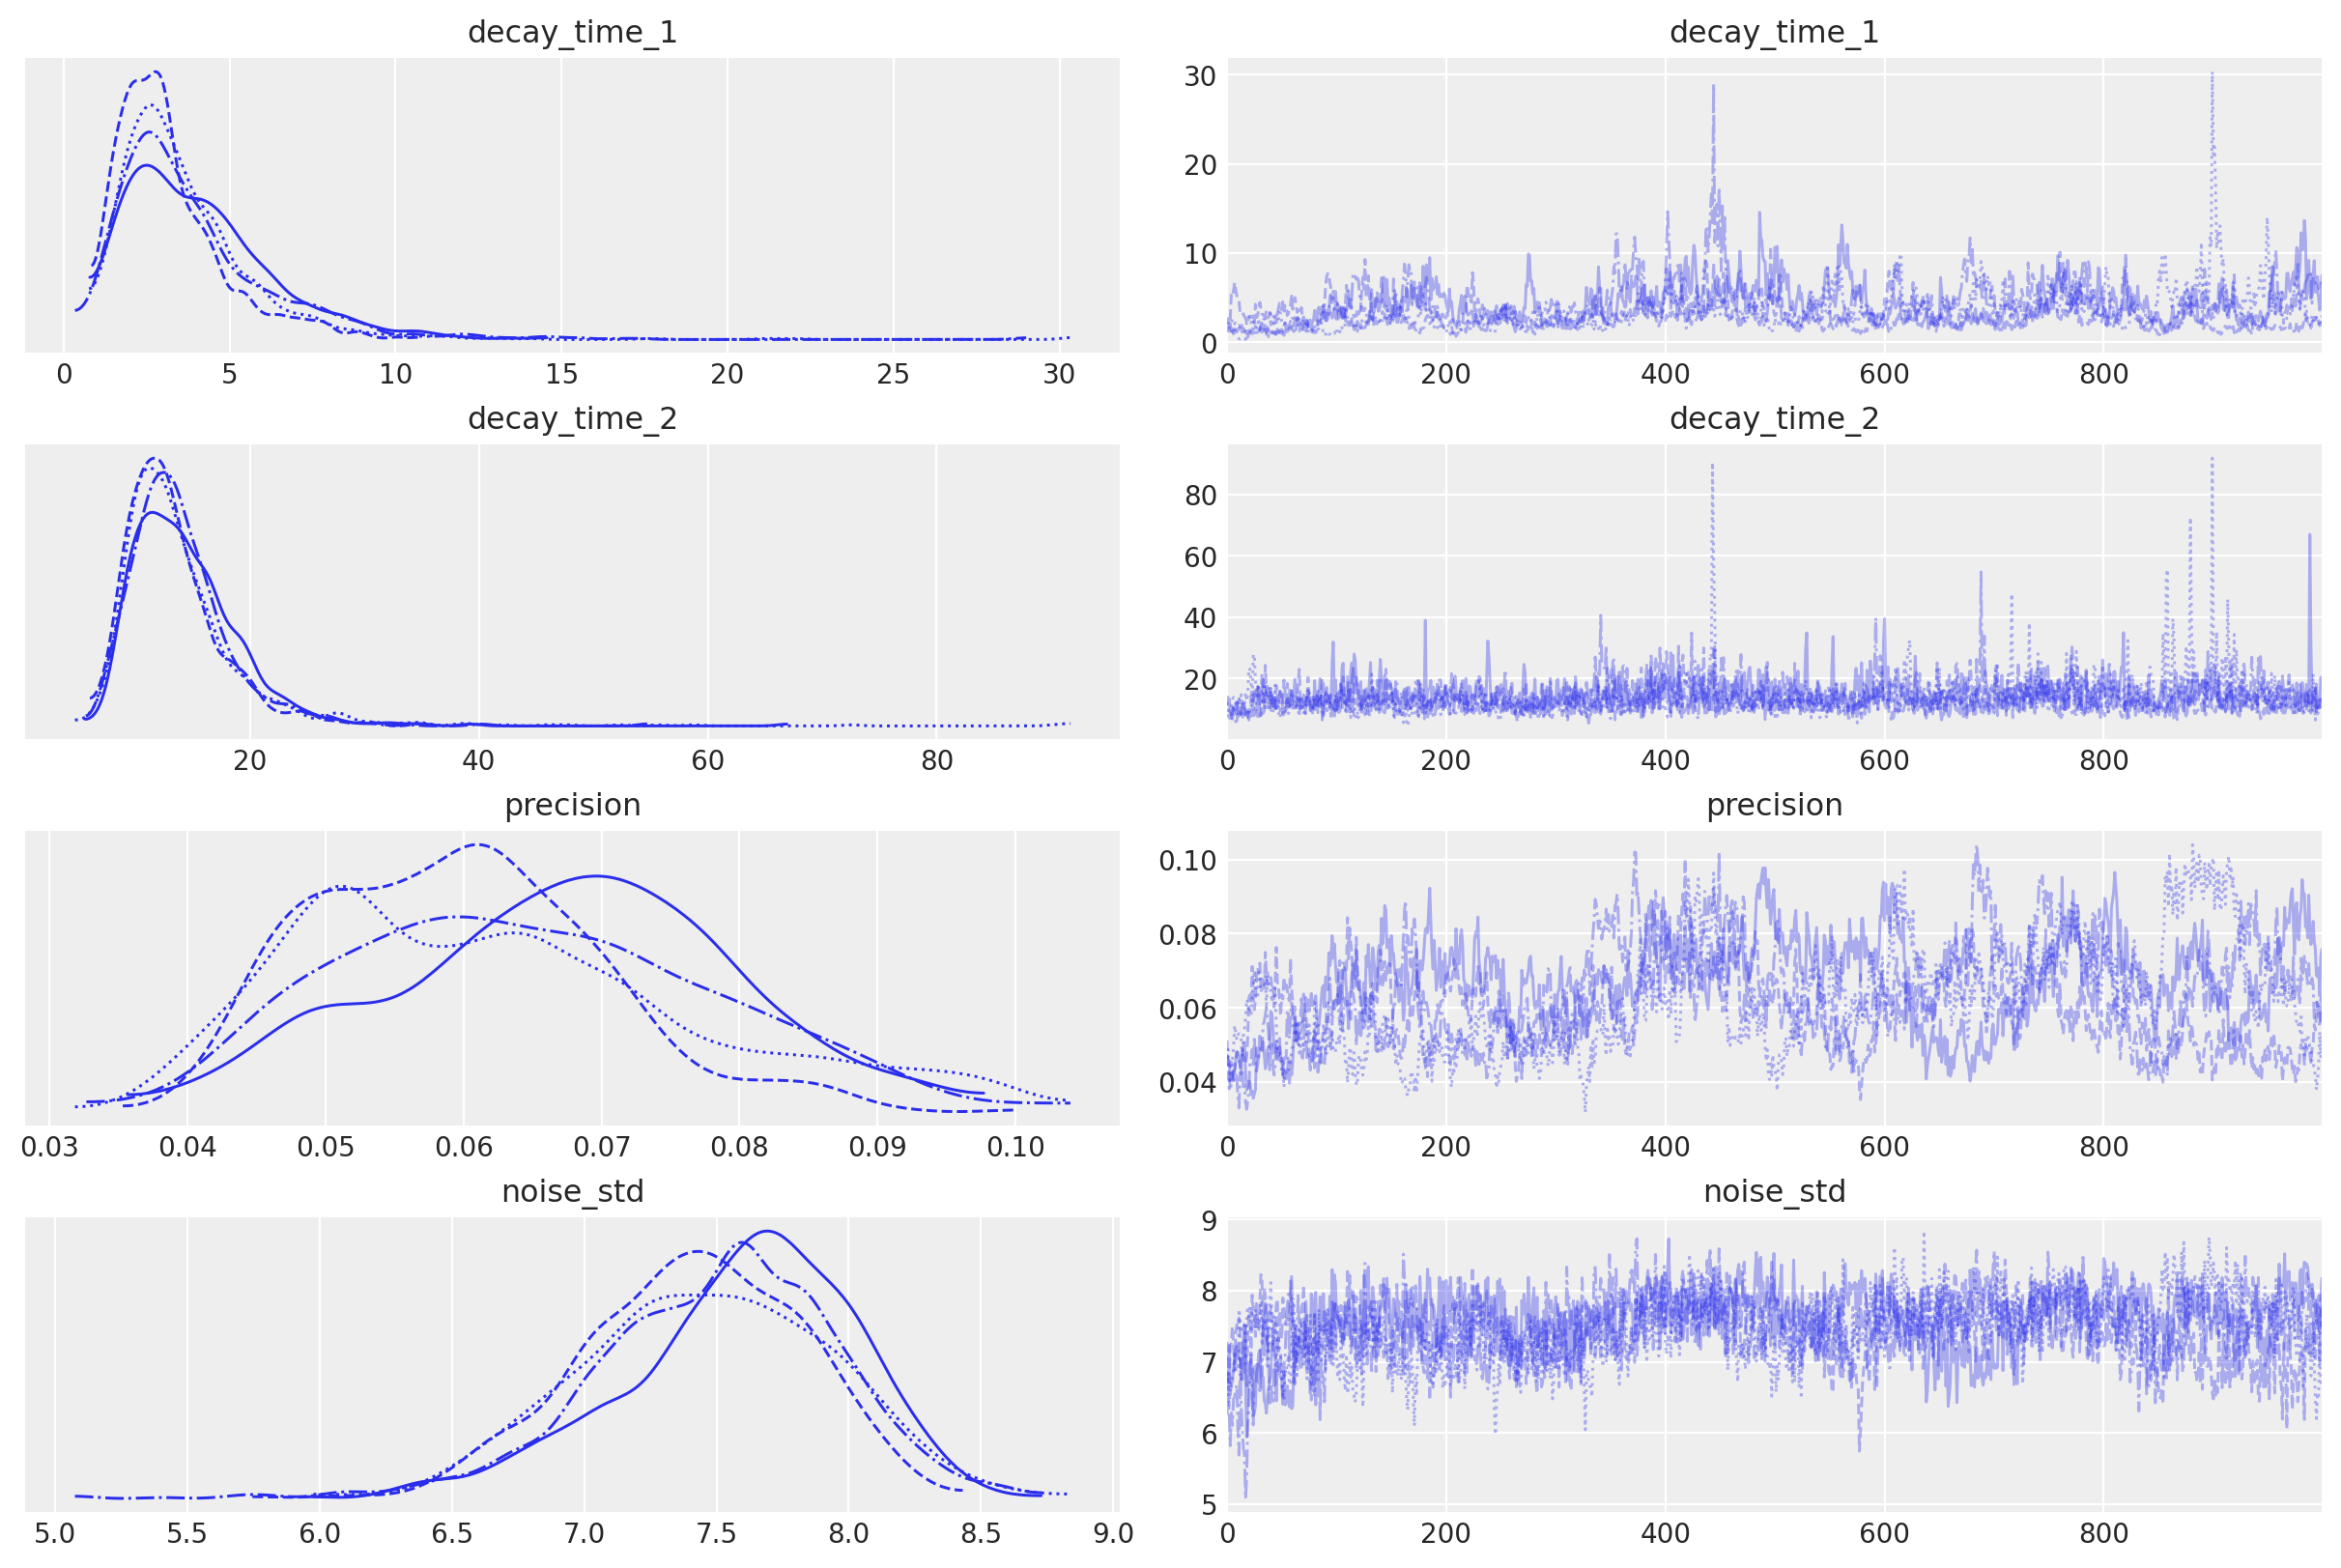

In [31]:
plot_trace(trace_multi_model, n_time_scale = 2)

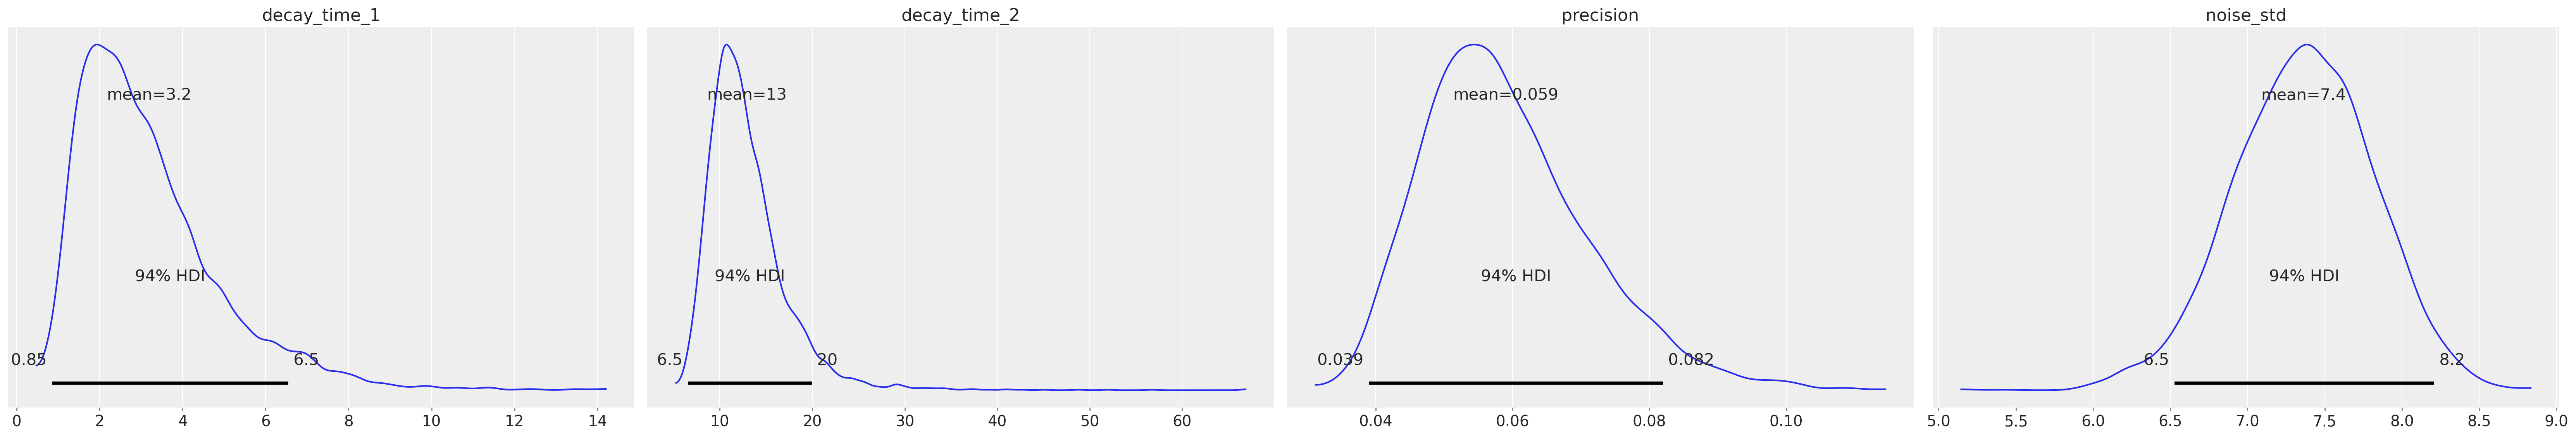

In [22]:
plot_posterior(trace_multi_model, n_time_scale = 2)

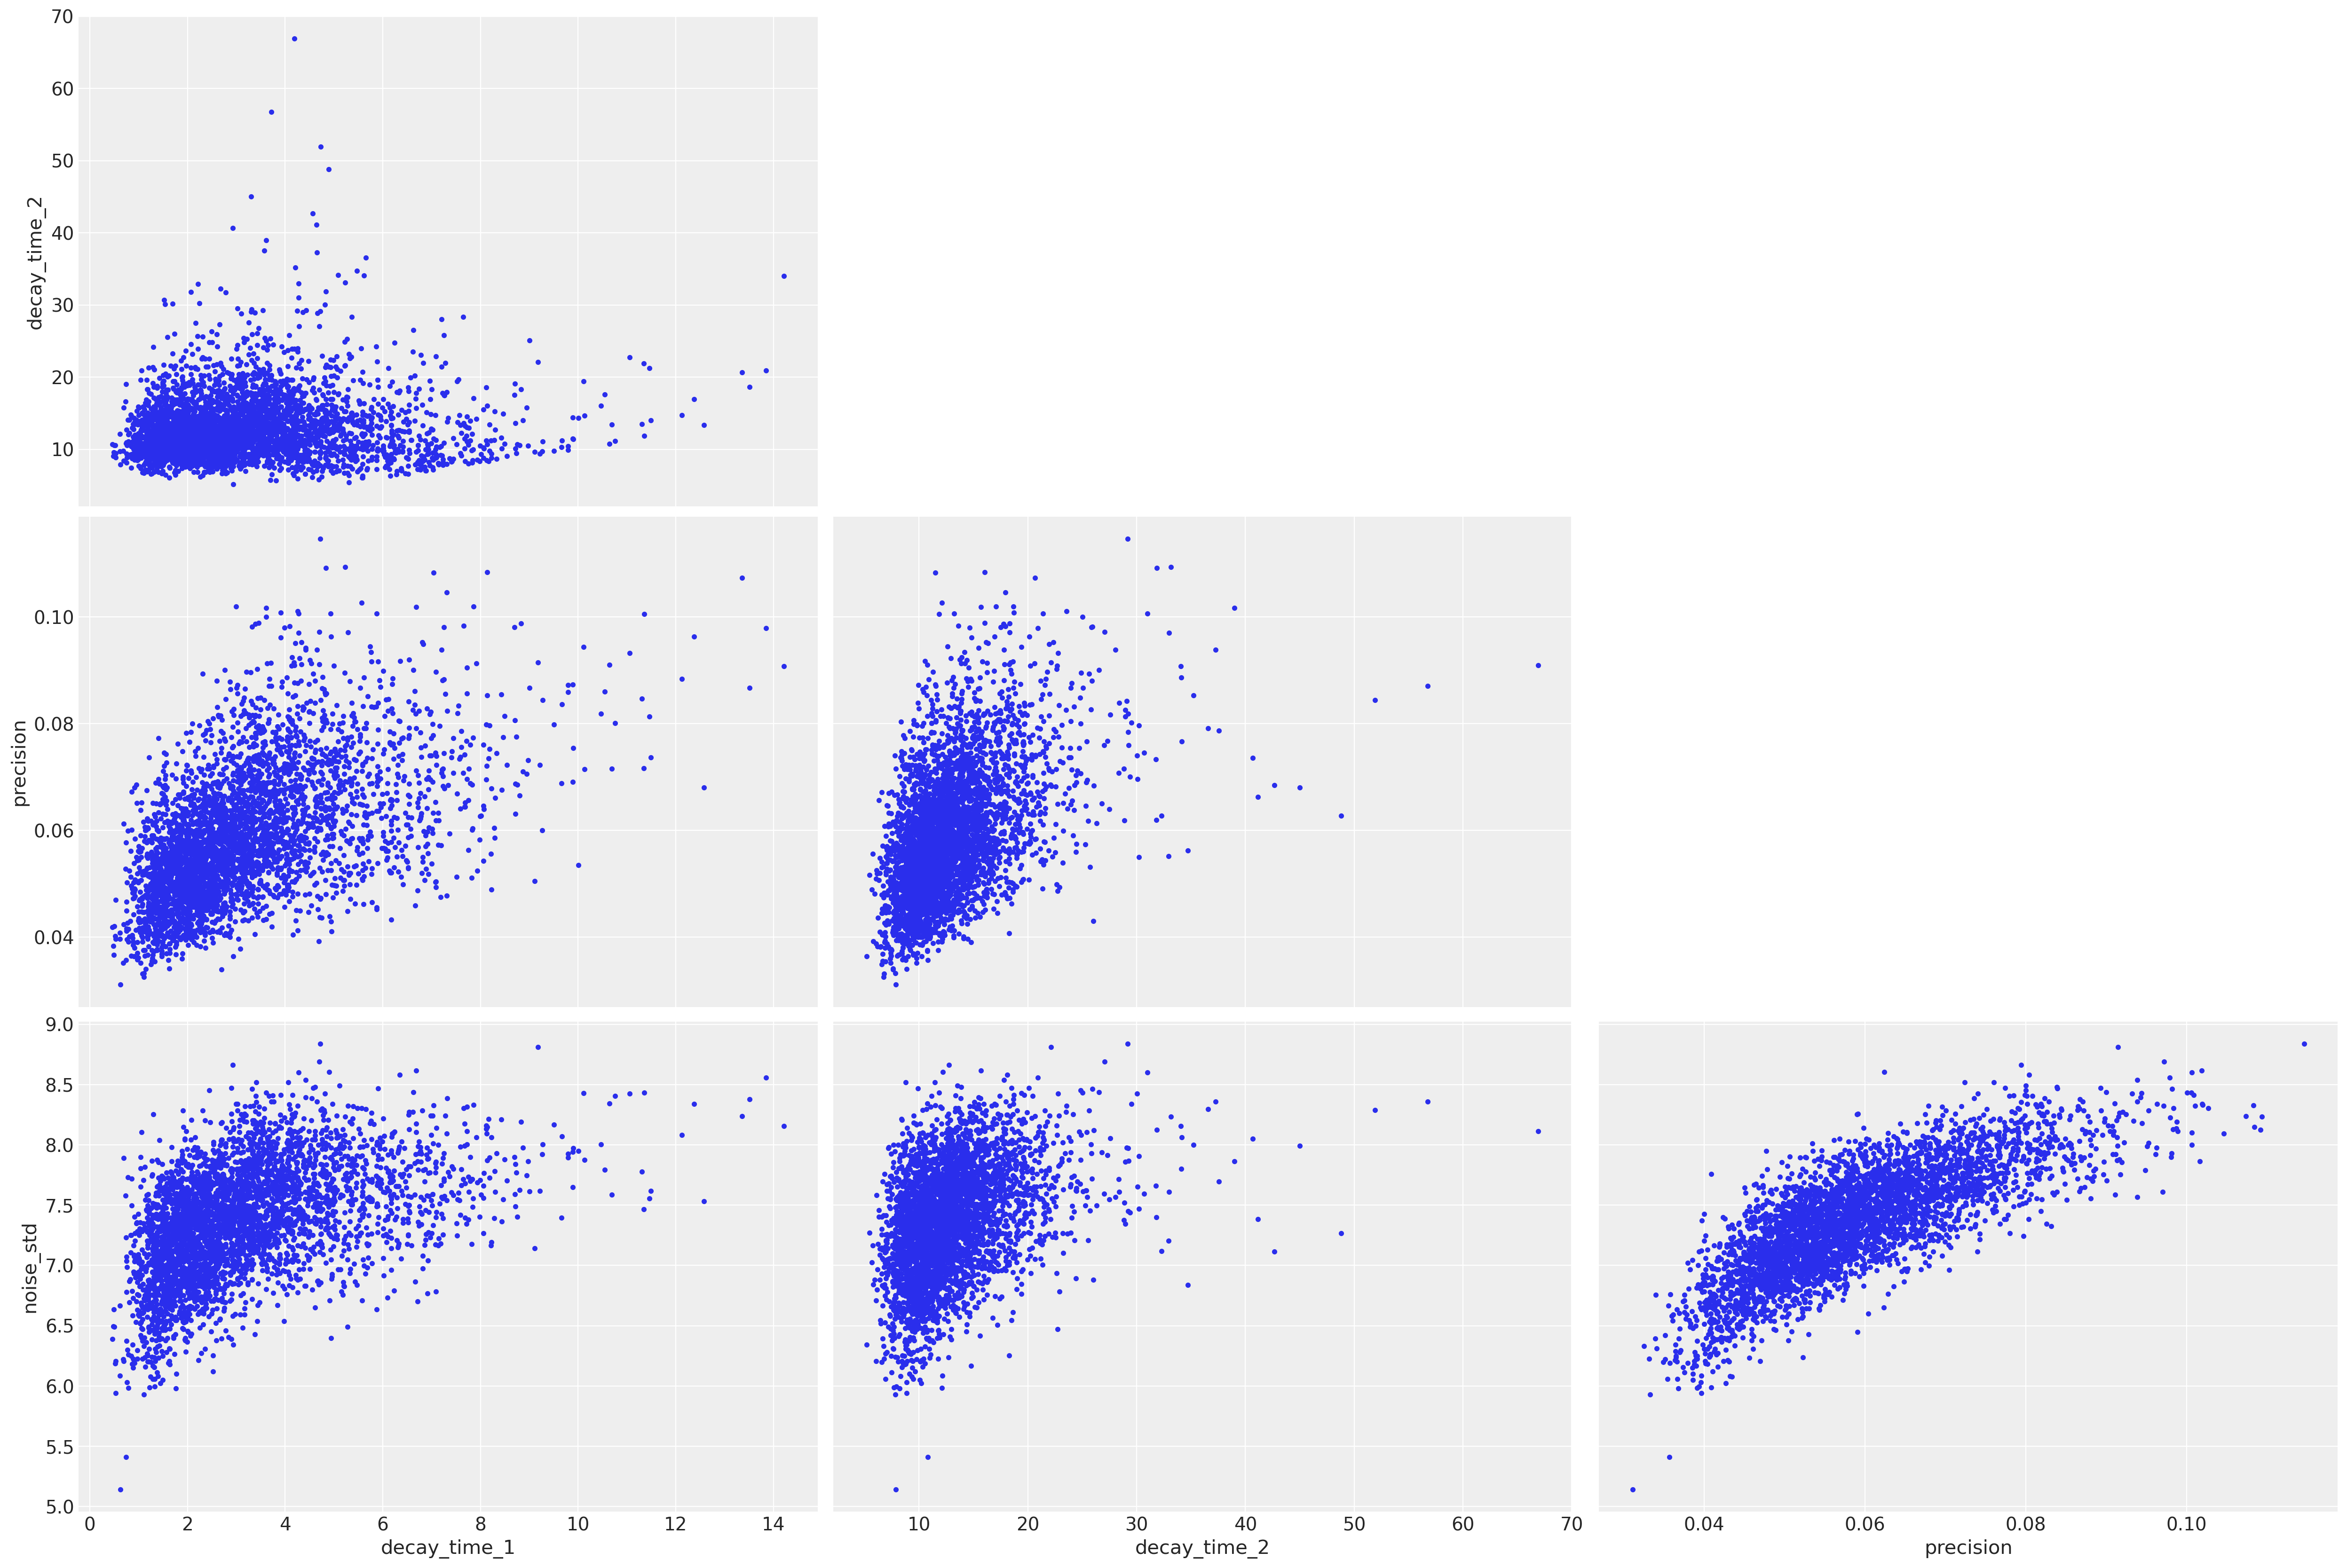

In [23]:
plot_pair(trace_multi_model, n_time_scale = 2)

In [24]:
ar1_multi_model1=set_single_precision_model(dataframe1['Intensity'], quantization)

In [25]:
# Sample with pymc3 using the double timescale model
trace_multi_model1 = run_model(ar1_multi_model1)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,740.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, noise_std, precision, decay_time_split, decay_time_1]


/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/anqichen/opt/anaconda3/envs/phys201/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 78 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tu

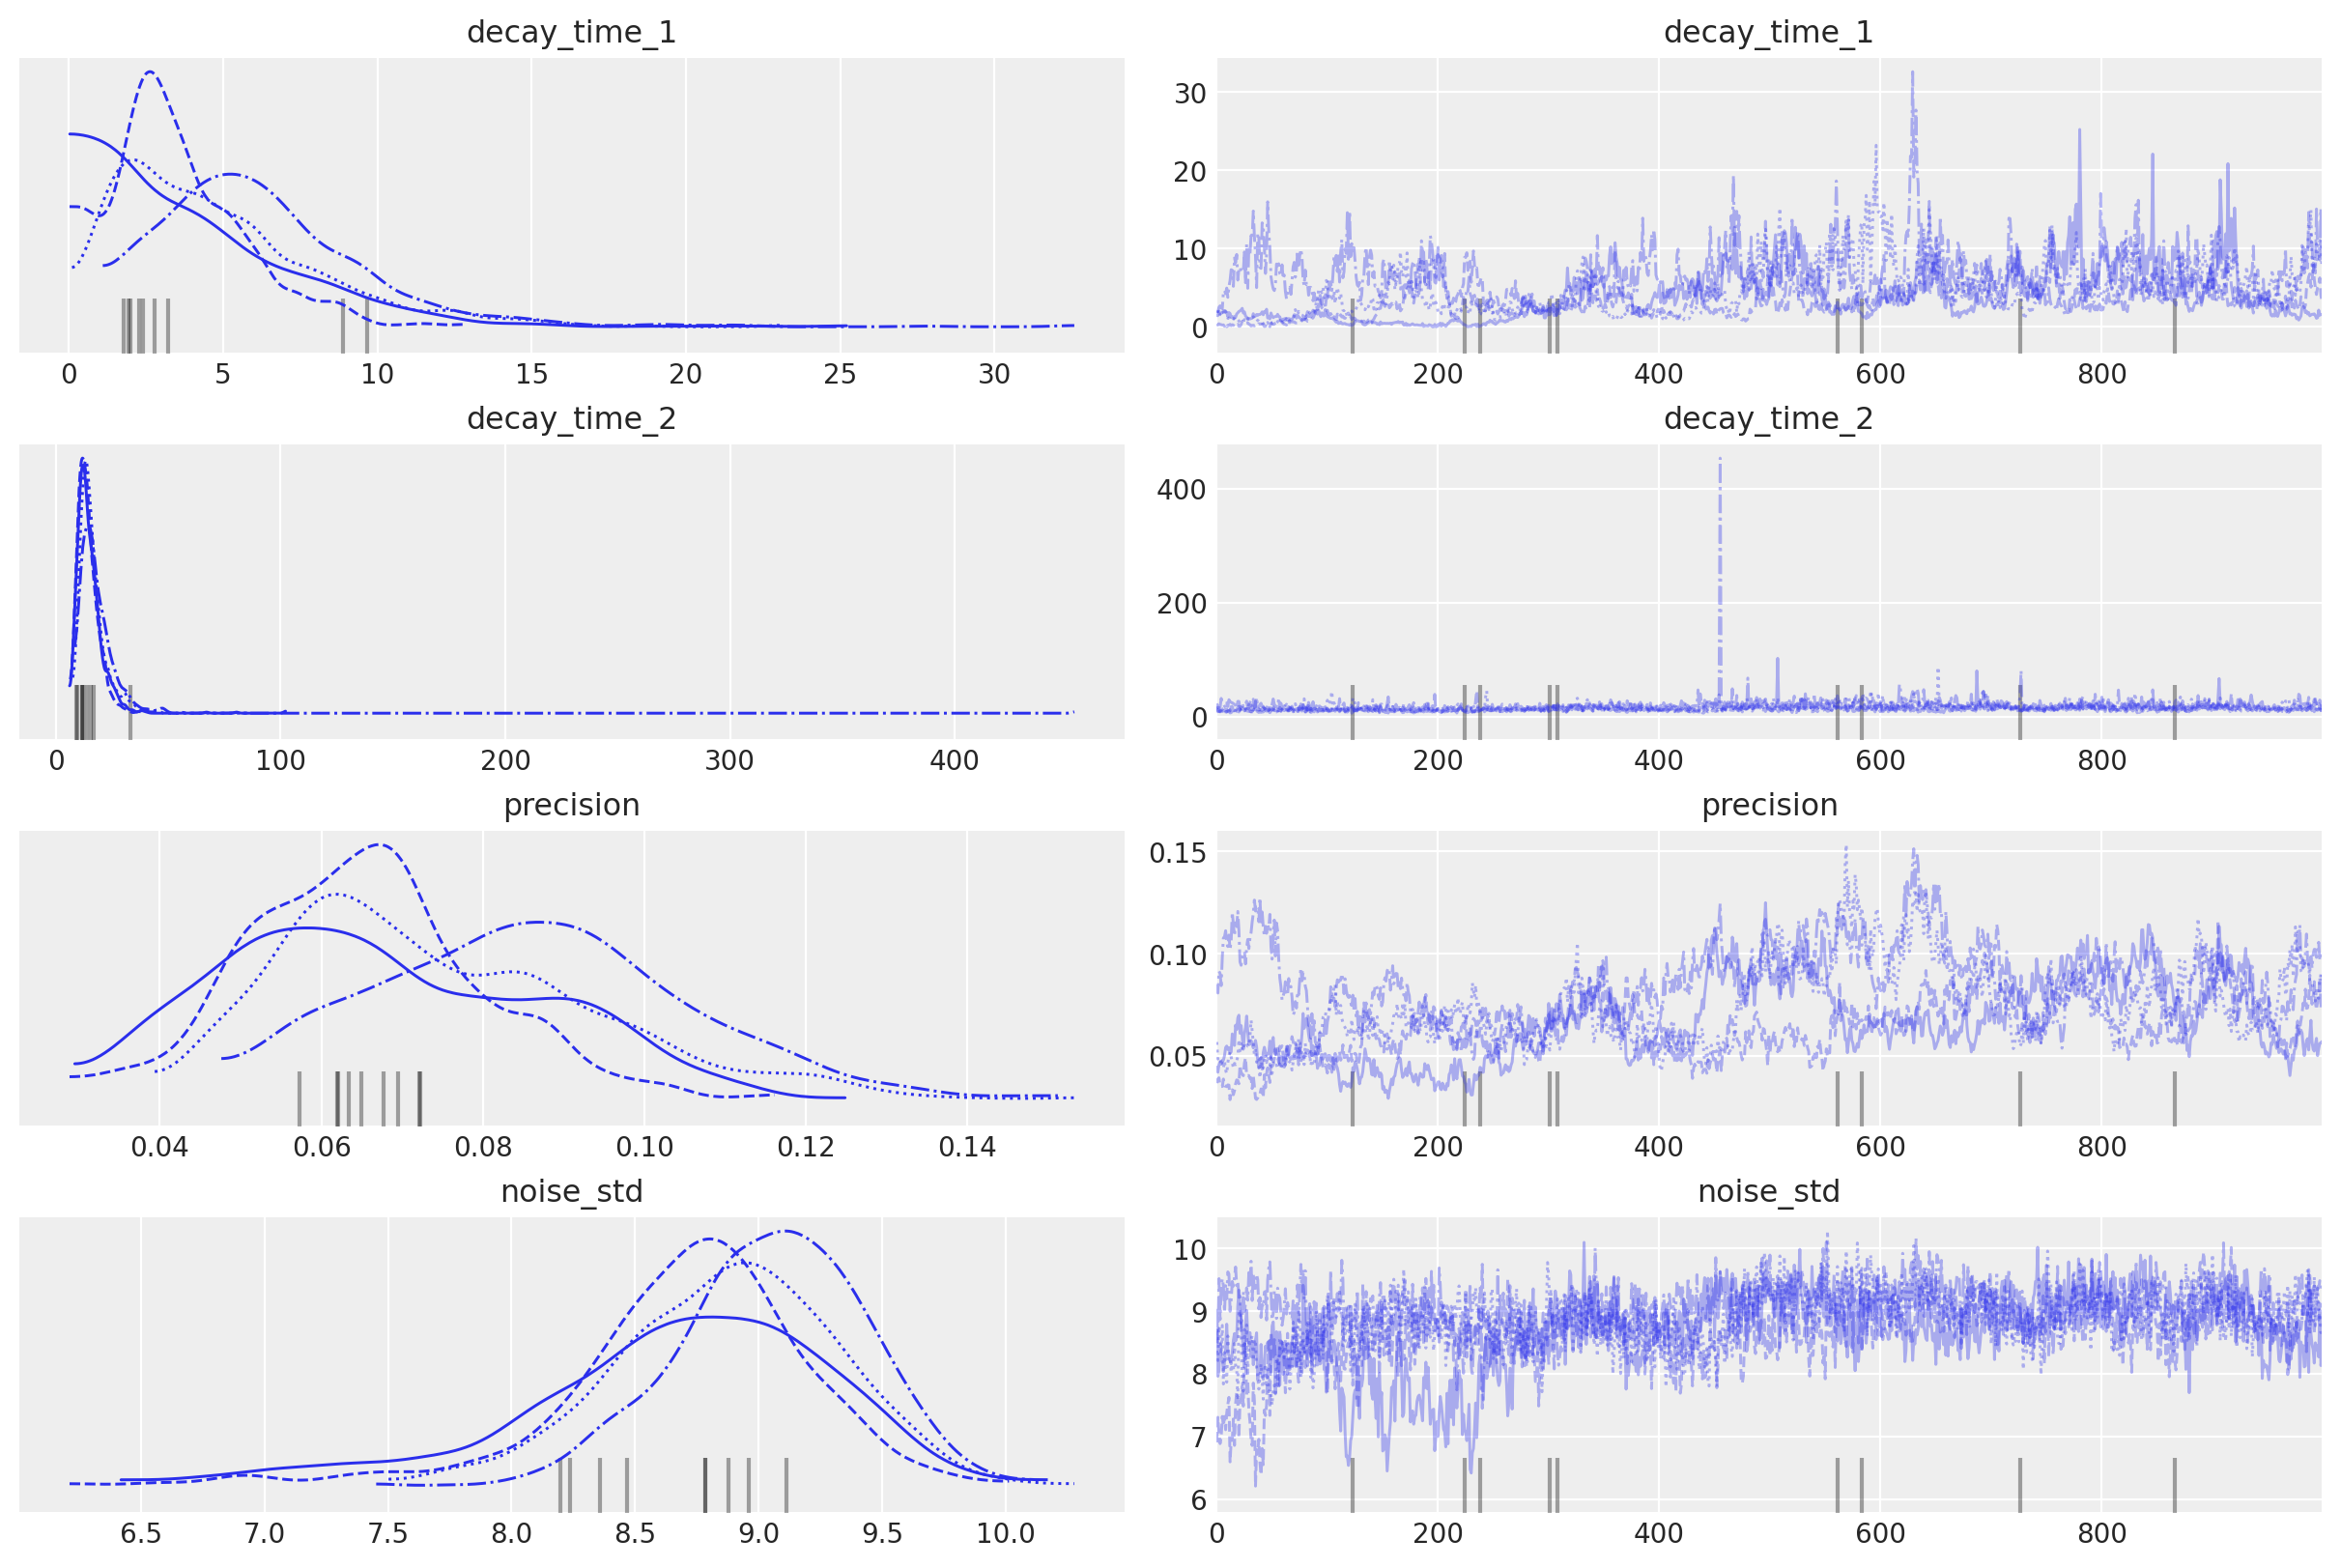

In [26]:
plot_trace(trace_multi_model1, n_time_scale = 2)

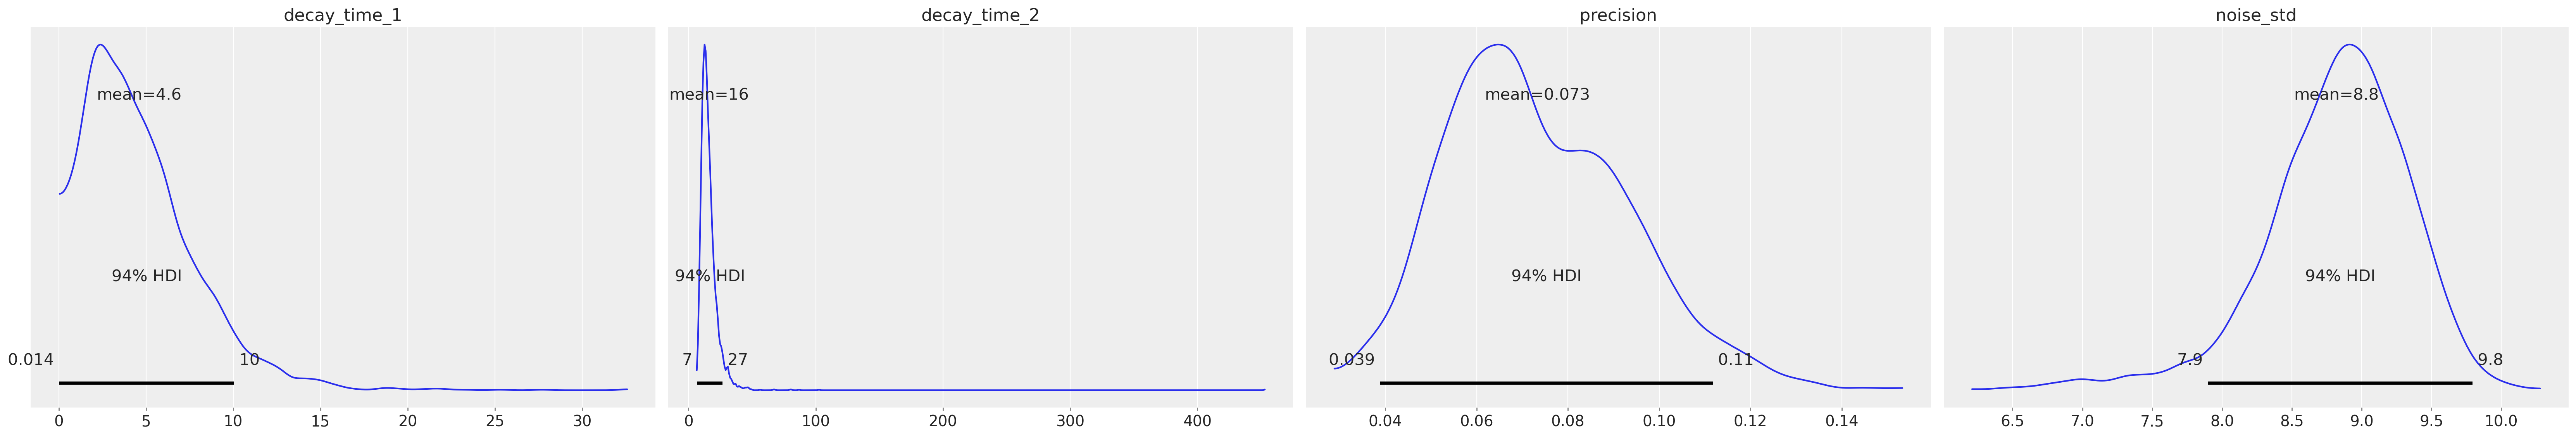

In [27]:
plot_posterior(trace_multi_model1, n_time_scale = 2)

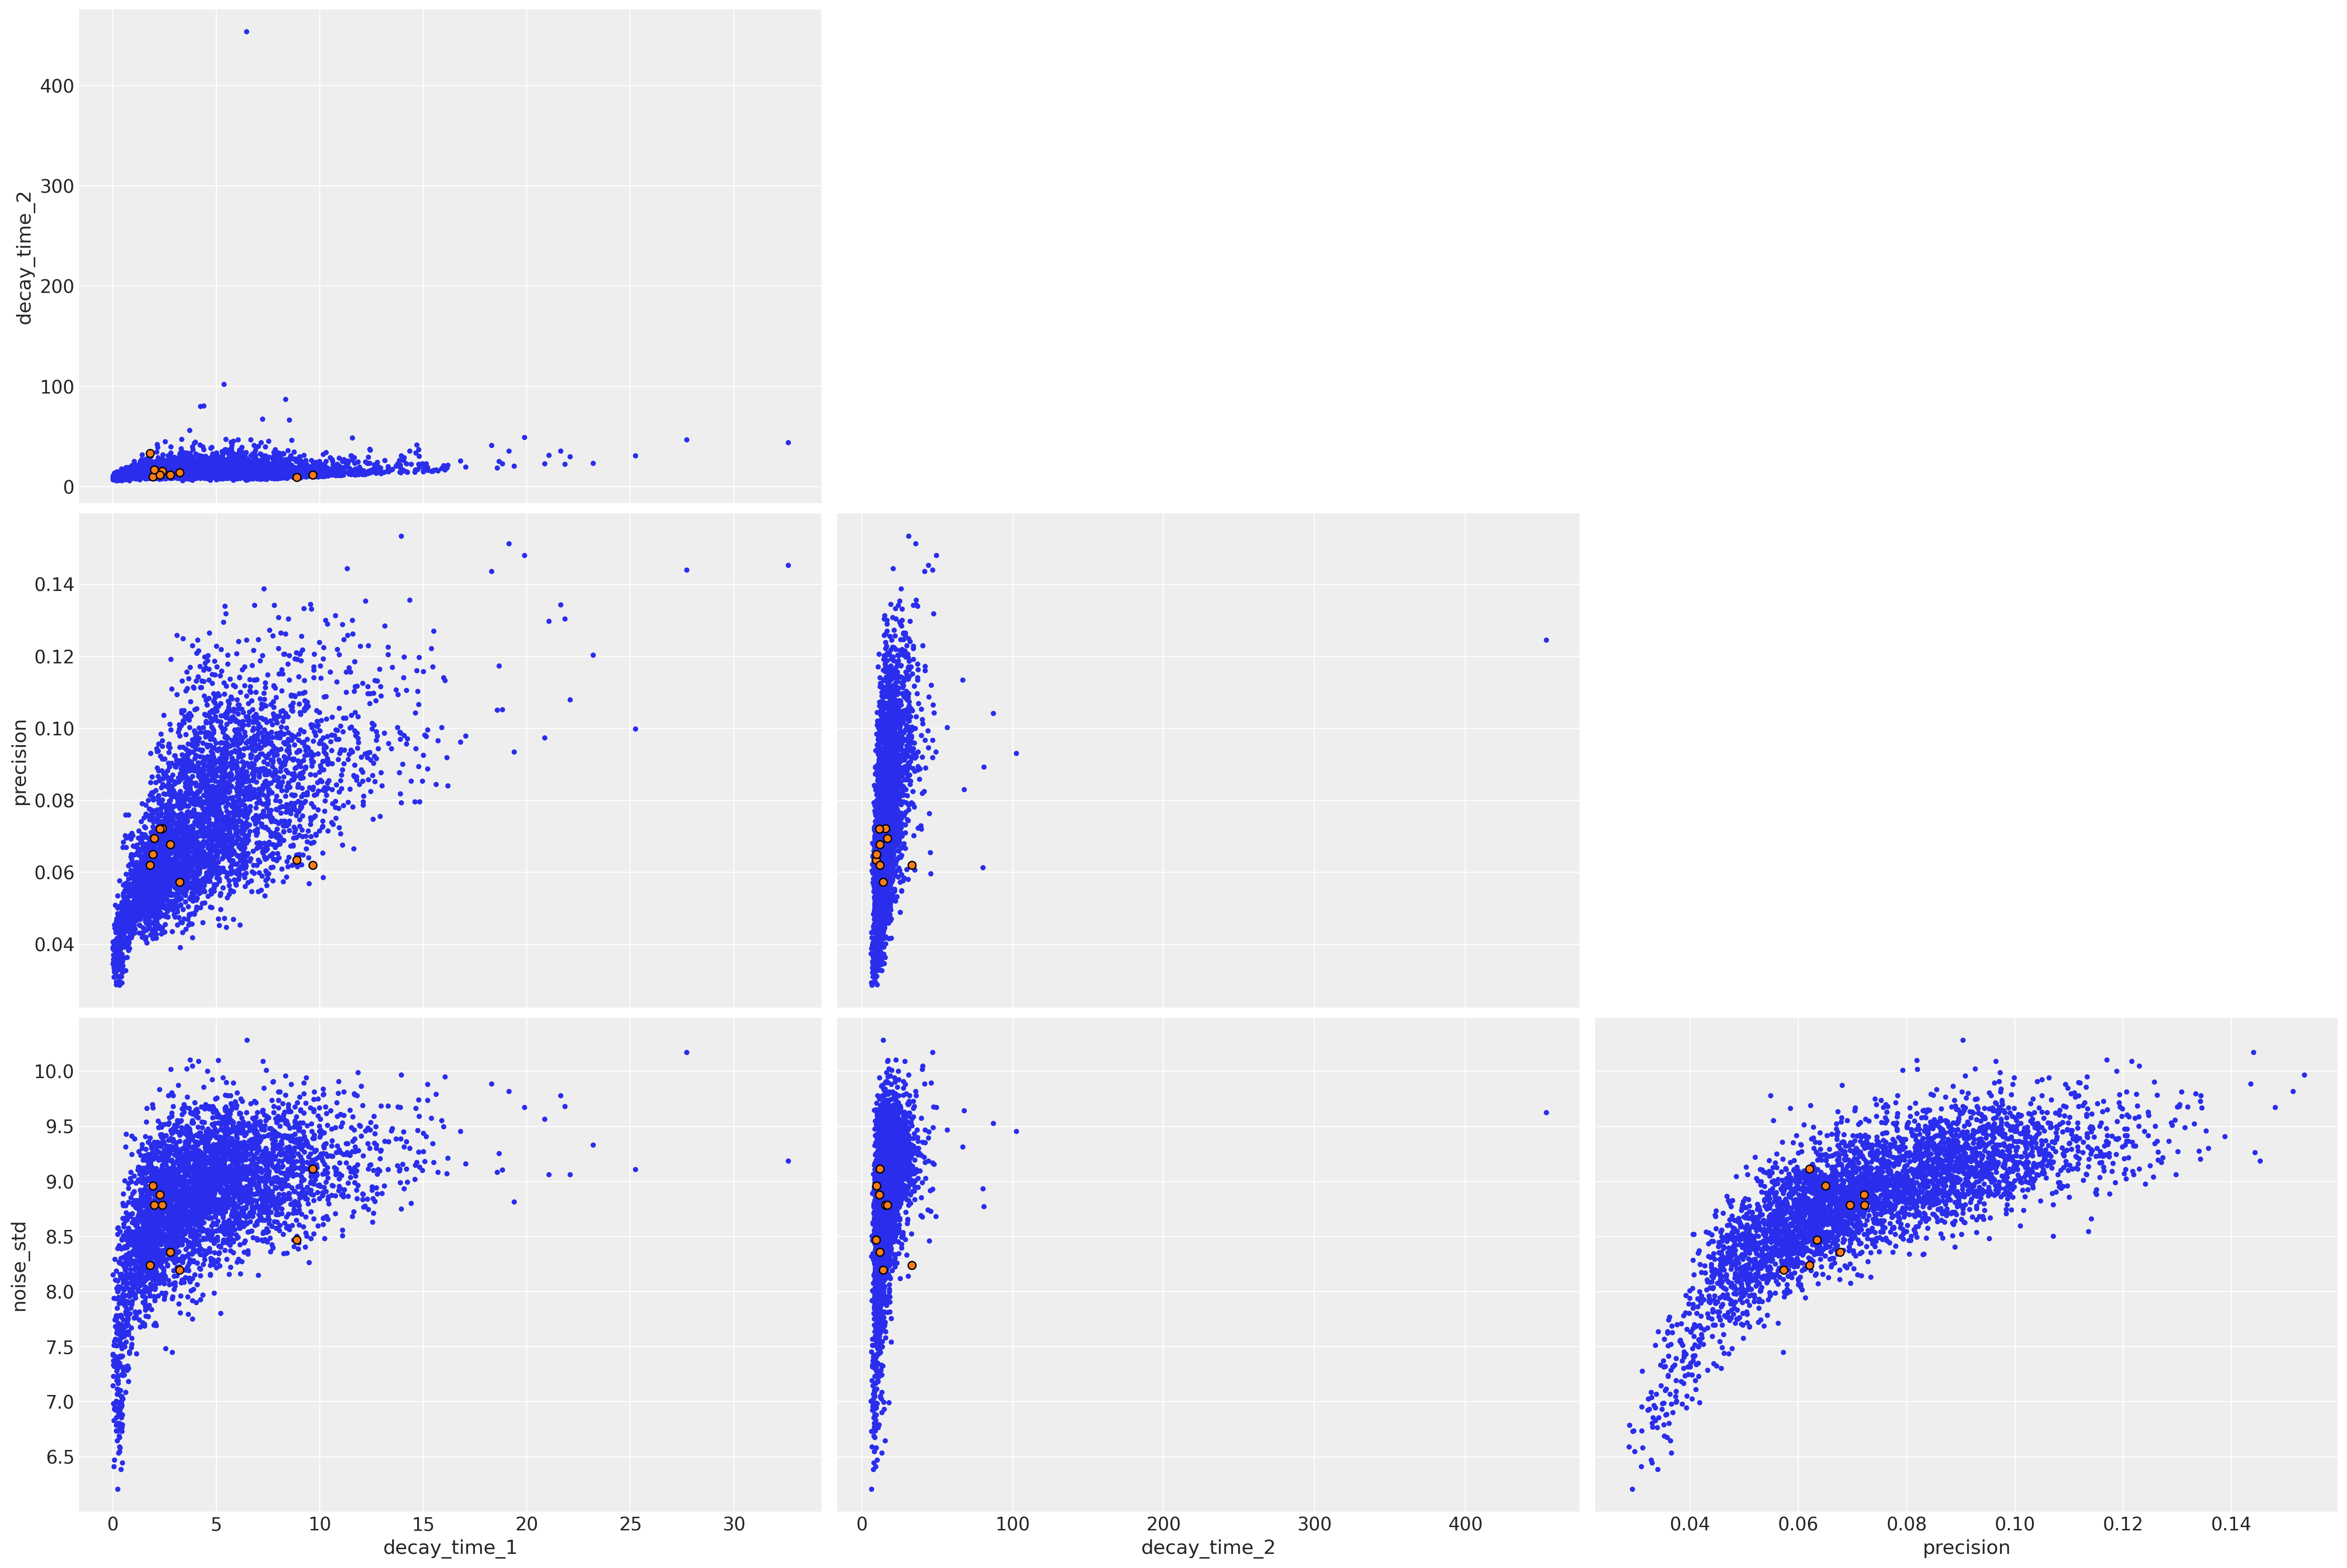

In [28]:
plot_pair(trace_multi_model1, n_time_scale = 2)